In [1]:
import pandas as pd
import river
from pprint import pprint
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import optim
from river import feature_extraction
from river import stats
import itertools
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime as dt
from river import ensemble
from river import stream
from river import datasets
from matplotlib.pyplot import figure
from river import facto
from river import compat
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.stattools import adfuller, kpss
from river import metrics
import matplotlib.pyplot as plt
from river import tree
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from river import neighbors
from river import multioutput
import scipy.stats as stats
from river import neural_net
from river import dummy
from river import compat
from river import time_series
import numpy as np
import matplotlib.patches as mpatches
import time
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import scipy
%matplotlib inline

In [2]:
# caricamento dati power Consumption House

dati_test = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TEST.txt", delim_whitespace=True, header=None)

dati_train = pd.read_csv("/home/giodefa/PycharmProjects/Script_Tesi_new/Dati/HouseTwenty/HouseTwenty_TRAIN.txt", delim_whitespace=True, header=None)

dati_train = dati_train.drop(0, axis= 1)
dati_test = dati_test.drop(0, axis= 1)

dati_train = dati_train.stack().reset_index()
dati_test = dati_test.stack().reset_index()

dati_train = dati_train.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_train = dati_train[['Count_days','Tick','PowerConsumption']]

dati_test = dati_test.rename(columns = {'level_0':'Count_days','level_1':'Tick',0:'PowerConsumption'})
dati_test = dati_test[['Count_days','Tick','PowerConsumption']]


# concateno i due dataset almeno per quanto riguarda lo sviluppo di algoritmi online

dati_complete_twe = pd.concat([dati_train, dati_test])

dati_complete_twe = dati_complete_twe[['Count_days', 'Tick', 'PowerConsumption']]
dati_complete_twe.to_csv('dati_PowerConsumption_twe')


dati_complete_twe = pd.read_csv('/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe')



dati_complete_twe = dati_complete_twe[['Count_days', 'Tick', 'PowerConsumption']]
dati_complete_twe


def initial_iter_twe():

       path = '/home/giodefa/PycharmProjects/Script_Tesi_new/Script/DatiTesi/dati_PowerConsumption_twe'

       X_y = stream.iter_csv(
              filepath_or_buffer=path,
              converters={
                     'Count_days': int,
                     'PowerConsumption': float,
                     'Tick': int
                     },
              target='PowerConsumption'
                      )
       return X_y

## Descriptive statistics and pre processing


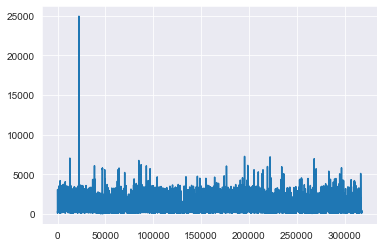

In [3]:
plt.plot(dati_complete_twe['PowerConsumption'])

<AxesSubplot:xlabel='PowerConsumption', ylabel='Count'>

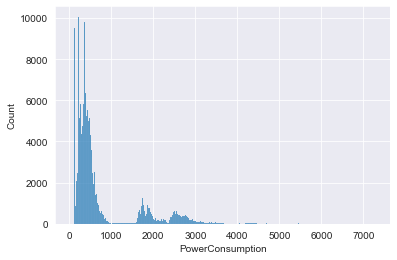

In [91]:
sns.histplot(dati_complete_twe['PowerConsumption'])

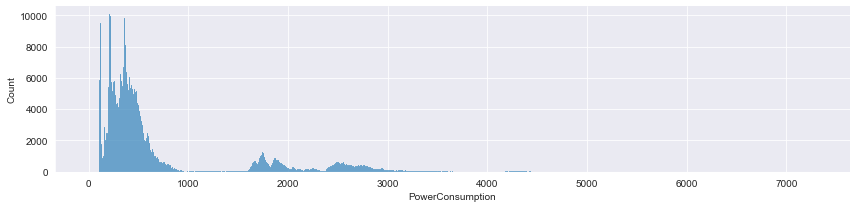

In [92]:
sns.displot(dati_complete_twe['PowerConsumption'], kind='hist', height=3, aspect=4)

/home/giodefa/anaconda3/envs/Script_Tesi_new/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PowerConsumption'>

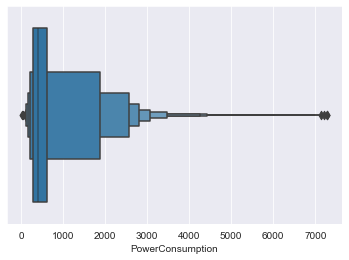

In [93]:
sns.boxenplot(dati_complete_twe['PowerConsumption'])

In [4]:
def plot_outliers(outliers, data, method='KNN',halignment = 'right',valignment = 'bottom',labels=False):
    ax = data.plot(alpha=0.6)
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}',
                     horizontalalignment=halignment,
                     verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        plt.title(f'Power Cons House - {method}')
        plt.xlabel('sample'); plt.ylabel('#Consuption')
        plt.legend(['Consuption','outliers'])
        plt.show()

In [94]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
dati_complete_twe['PowerConsumption'].describe(percentiles= percentiles)

count    317999.000000
mean        739.005362
std         819.119676
min          27.000000
0%           27.000000
5%          130.000000
10%         204.000000
25%         273.000000
50%         408.000000
75%         615.000000
90%        2091.000000
95%        2638.000000
100%       7273.000000
max        7273.000000
Name: PowerConsumption, dtype: float64

In [60]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data['PowerConsumption'] - data['PowerConsumption'].mean())/data['PowerConsumption'].std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]

    return outliers

In [95]:
threshold = 2.5
outliers = zscore(dati_complete_twe, threshold)

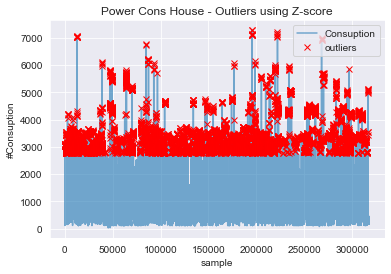

In [96]:
plot_outliers(outliers, dati_complete_twe['PowerConsumption'], "Outliers using Z-score")

In [67]:
def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [97]:
test_normal(dati_complete_twe['PowerConsumption'])

Reject null hypothesis. Data is not normal


In [70]:
def modified_zscore(df, degree = 3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data['PowerConsumption'] - data['PowerConsumption'].median())
    MAD = np.abs(data['PowerConsumption'] - data['PowerConsumption'].median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]

    return outliers, data['PowerConsumption']

In [98]:
threshold = 3
outliers, transformed = modified_zscore (dati_complete_twe, threshold)

<AxesSubplot:>

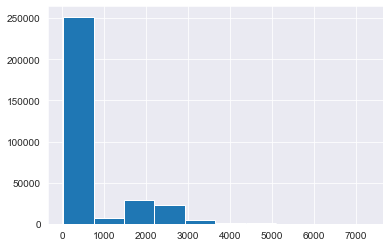

In [99]:
transformed.hist()

In [87]:
dati_complete_twe.drop(dati_complete_twe[dati_complete_twe['PowerConsumption'] == 24929.000000 ].index, inplace = True)

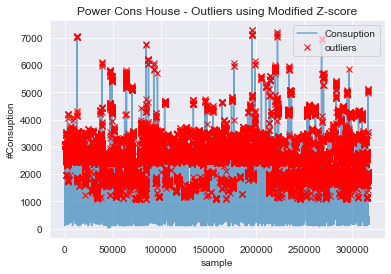

In [100]:
plot_outliers(outliers, dati_complete_twe['PowerConsumption'], "Outliers using Modified Z-score")

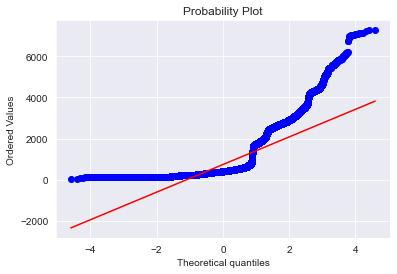

In [89]:
res = scipy.stats.probplot(dati_complete_twe['PowerConsumption'].values.reshape(-1), plot=plt)

In [104]:
twe_decomposition = seasonal_decompose(dati_complete_twe['PowerConsumption'], model = 'additive', period=365)

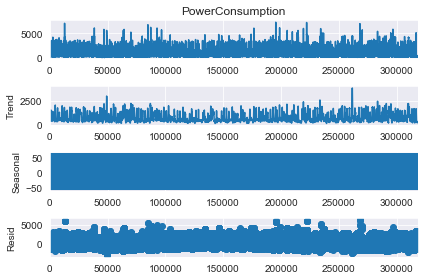

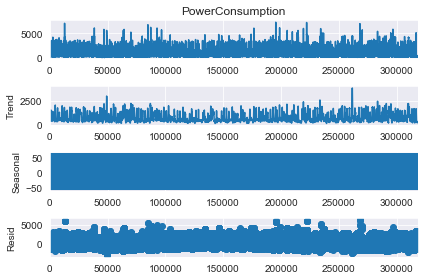

In [105]:
twe_decomposition.plot()

In [4]:
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

In [ ]:
adf_output = adfuller(dati_complete_twe['PowerConsumption'])
kpss_output = kpss(dati_complete_twe['PowerConsumption'])

In [ ]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

# Power Consumption House

## MLP Online vs MLP Batch


### MLP Online

100%|██████████| 318000/318000 [10:45<00:00, 492.72it/s]


Execution time: 645.4067771434784 seconds


Text(0.5, 1.0, 'MSE: 338,616.33375')

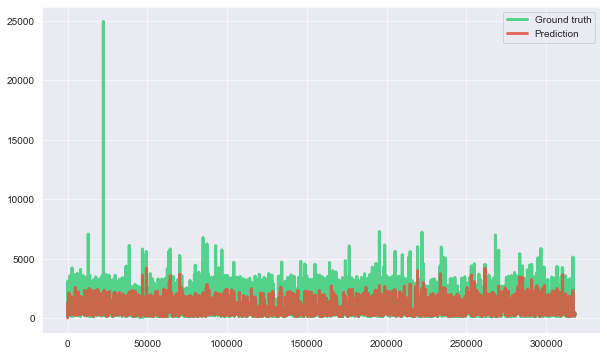

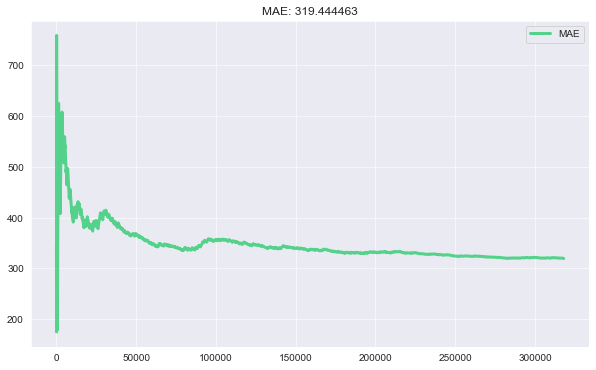

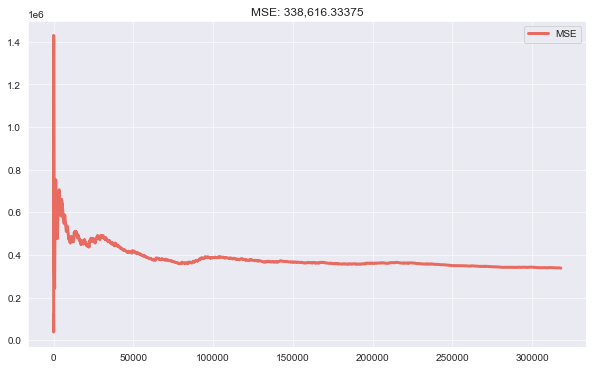

In [3]:
metric_mae_ml_online = metrics.MAE()
metric_mse_ml_online = metrics.MSE()

dates_ml_online = []
y_trues_ml_online = []
y_preds_ml_online = []
metrics_MAE_ml_online = []
metrics_MSE_ml_online = []

X_y = initial_iter_twe()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(16, 32, 64),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD()
       )
)


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #318000
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric ultimo 30%
       metric_mae_ml_online.update(y, y_pred)
       metric_mse_ml_online.update(y, y_pred)
       metrics_MAE_ml_online.append(metric_mae_ml_online.get())
       metrics_MSE_ml_online.append(metric_mse_ml_online.get())

       # Store the true value and the prediction
       dates_ml_online.append(i)
       y_trues_ml_online.append(y)
       y_preds_ml_online.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, y_trues_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ml_online, y_preds_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MAE_ml_online, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ml_online)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ml_online, metrics_MSE_ml_online, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ml_online)

In [21]:
X_y = initial_iter_twe()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(16, 32, 64),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD()
       )
)


evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       delay=83,
       print_every=3000
)

[3,000] MAE: 654.447283
[6,000] MAE: 623.043656
[9,000] MAE: 560.698302
[12,000] MAE: 552.586178
[15,000] MAE: 559.013533
[18,000] MAE: 549.068013
[21,000] MAE: 530.903397
[24,000] MAE: 536.847028
[27,000] MAE: 542.961578
[30,000] MAE: 551.276829
[33,000] MAE: 543.92855
[36,000] MAE: 528.596579
[39,000] MAE: 528.75473
[42,000] MAE: 518.766425
[45,000] MAE: 519.57757
[48,000] MAE: 520.306787
[51,000] MAE: 525.997626
[54,000] MAE: 519.572367
[57,000] MAE: 518.965517
[60,000] MAE: 511.597947
[63,000] MAE: 512.362898
[66,000] MAE: 517.925146
[69,000] MAE: 520.510451
[72,000] MAE: 519.645394
[75,000] MAE: 516.246802
[78,000] MAE: 512.422564
[81,000] MAE: 516.435776
[84,000] MAE: 510.516011
[87,000] MAE: 510.709796
[90,000] MAE: 514.609632
[93,000] MAE: 524.321181
[96,000] MAE: 521.972569
[99,000] MAE: 521.784121
[102,000] MAE: 523.378699
[105,000] MAE: 524.808906
[108,000] MAE: 522.713368
[111,000] MAE: 518.731816
[114,000] MAE: 512.889788
[117,000] MAE: 511.223153
[120,000] MAE: 506.421481

MAE: 491.272877

In [23]:
X_y = initial_iter_twe()

model = compose.Select()
model |= (
       preprocessing.StandardScaler() |
       neural_net.MLPRegressor(
              hidden_dims=(16, 32, 64),
              activations=(
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.Identity
              ),
              optimizer=optim.SGD()
       )
)



evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=83,
       print_every=3000
)

[3,000] MSE: 901,054.167205
[6,000] MSE: 861,446.883158
[9,000] MSE: 781,672.189775
[12,000] MSE: 777,203.94877
[15,000] MSE: 808,178.62272
[18,000] MSE: 794,423.28129
[21,000] MSE: 760,906.689168
[24,000] MSE: 784,784.720558
[27,000] MSE: 787,844.237783
[30,000] MSE: 784,067.312946
[33,000] MSE: 768,770.274311
[36,000] MSE: 736,837.147576
[39,000] MSE: 736,947.817959
[42,000] MSE: 718,867.36525
[45,000] MSE: 715,960.804057
[48,000] MSE: 716,520.040356
[51,000] MSE: 742,349.184434
[54,000] MSE: 727,048.006979
[57,000] MSE: 723,517.311812
[60,000] MSE: 705,114.357944
[63,000] MSE: 709,520.940902
[66,000] MSE: 724,863.029163
[69,000] MSE: 723,454.443958
[72,000] MSE: 728,555.618979
[75,000] MSE: 716,720.476971
[78,000] MSE: 705,232.045226
[81,000] MSE: 708,970.045434
[84,000] MSE: 699,359.83657
[87,000] MSE: 703,200.265782
[90,000] MSE: 708,222.011463
[93,000] MSE: 719,560.231961
[96,000] MSE: 714,319.846583
[99,000] MSE: 715,028.328396
[102,000] MSE: 718,141.059832
[105,000] MSE: 723,76

MSE: 671,038.020694

### MLP Batch

In [4]:

X_mlp = dati_complete_twe['PowerConsumption'].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_mlp, y_mlp = split_sequence(X_mlp, 1)

X_train_mlp, X_test_mlp, Y_train_mlp, Y_test_mlp = train_test_split(X_mlp, y_mlp, random_state=1, train_size=0.7, shuffle=False)



# get the start time
st = time.time()

regr_mlp = MLPRegressor(random_state=1, max_iter=2000, hidden_layer_sizes=(16, 32, 64)).fit(X_train_mlp, Y_train_mlp)




result_mlpBatch = regr_mlp.predict(X_test_mlp).reshape(-1,1)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')



Execution time: 117.88544964790344 seconds


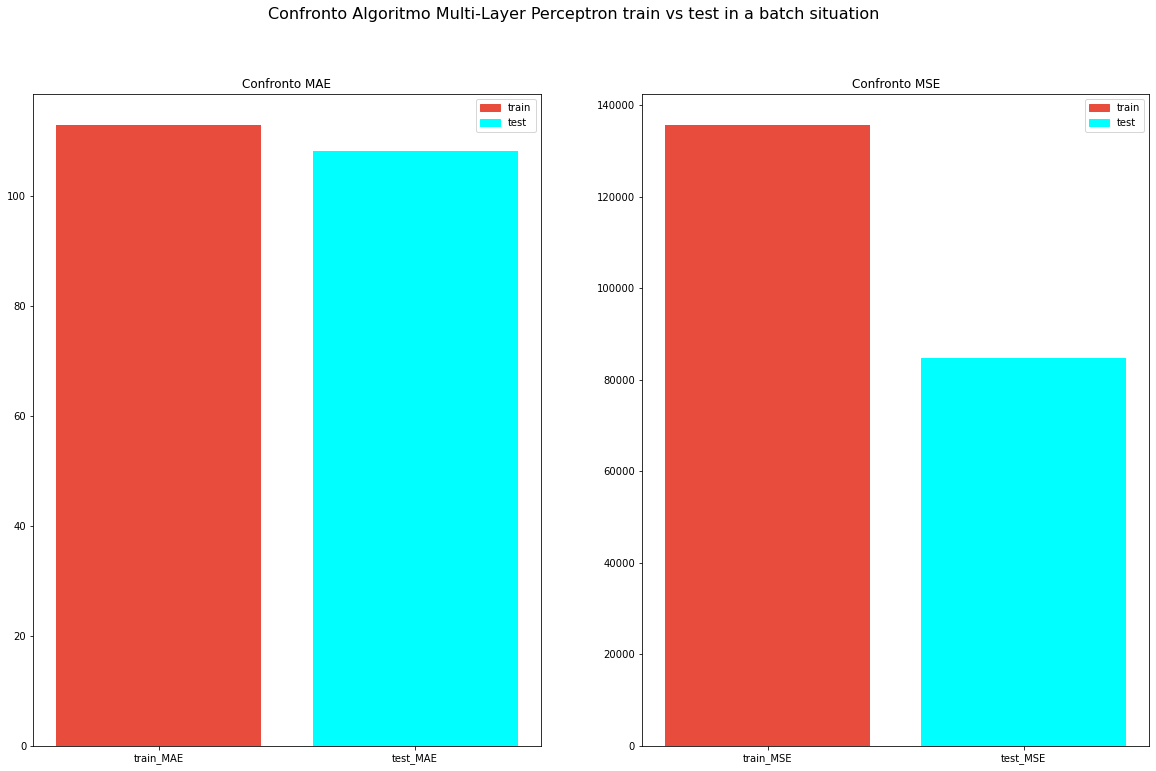

In [31]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_mlp, regr_mlp.predict(X_train_mlp)),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_mlp, regr_mlp.predict(X_train_mlp)),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

In [37]:
len(Y_test_mlp)

95400

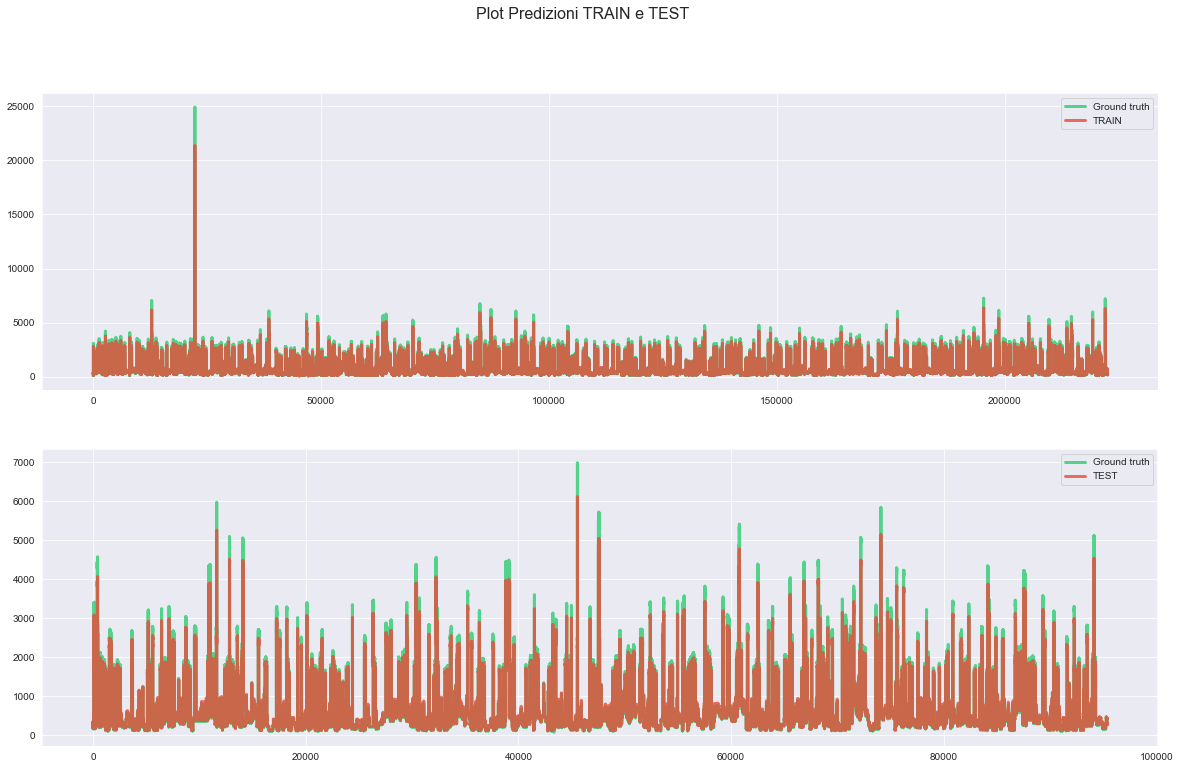

In [5]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(regr_mlp.predict(X_train_mlp), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(regr_mlp.predict(X_test_mlp), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto MLP Batch vs MLP Online


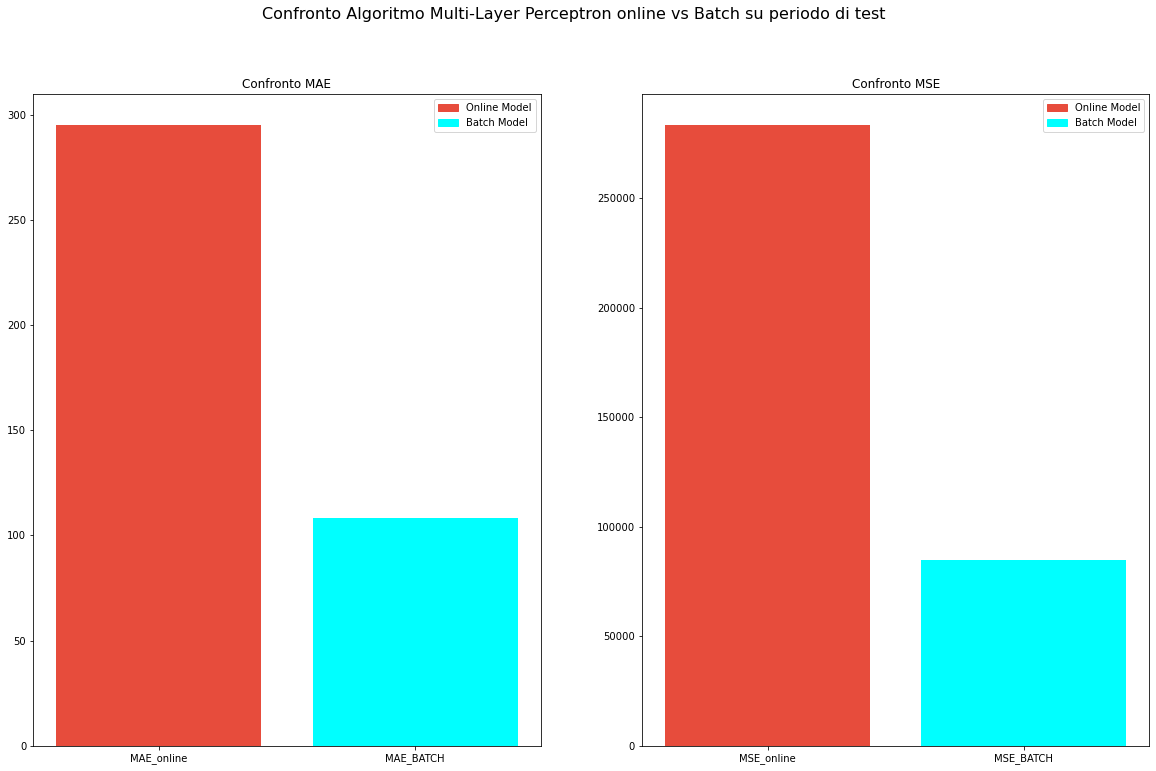

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_mlp, y_preds_ml_online[-95400::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_mlp, y_preds_ml_online[-95400::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

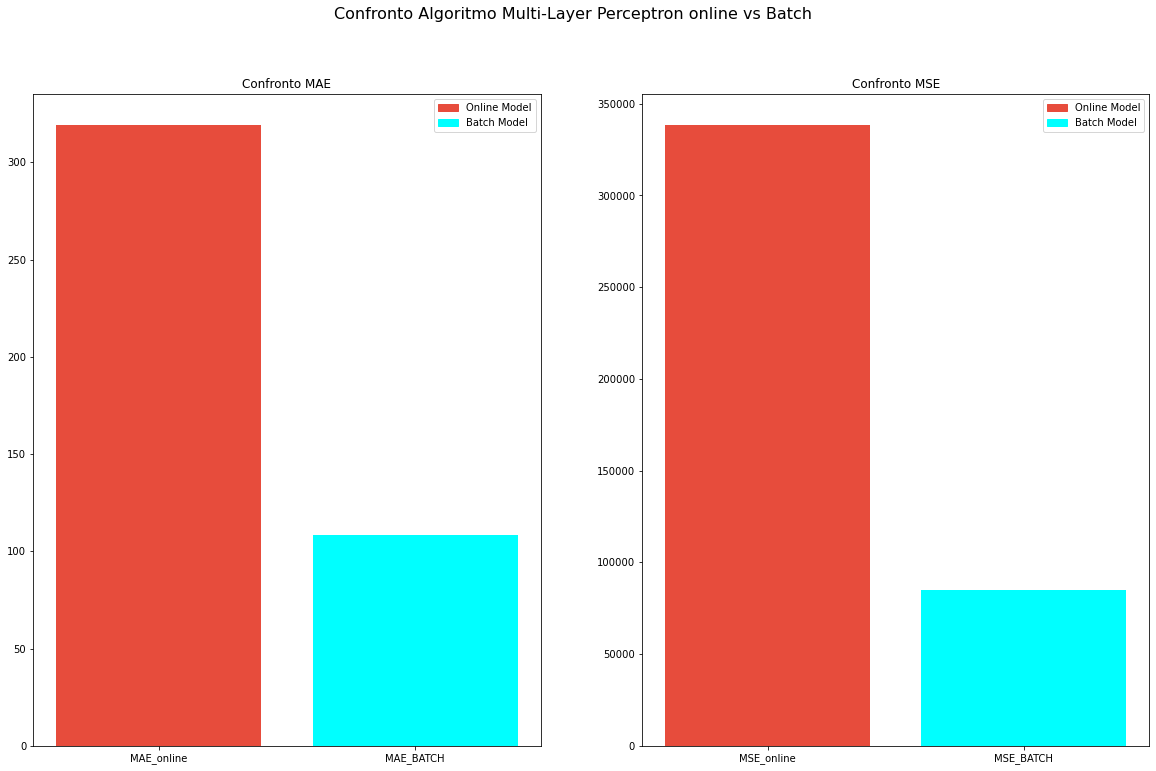

In [42]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_ml_online[-1],mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ml_online[-1],mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

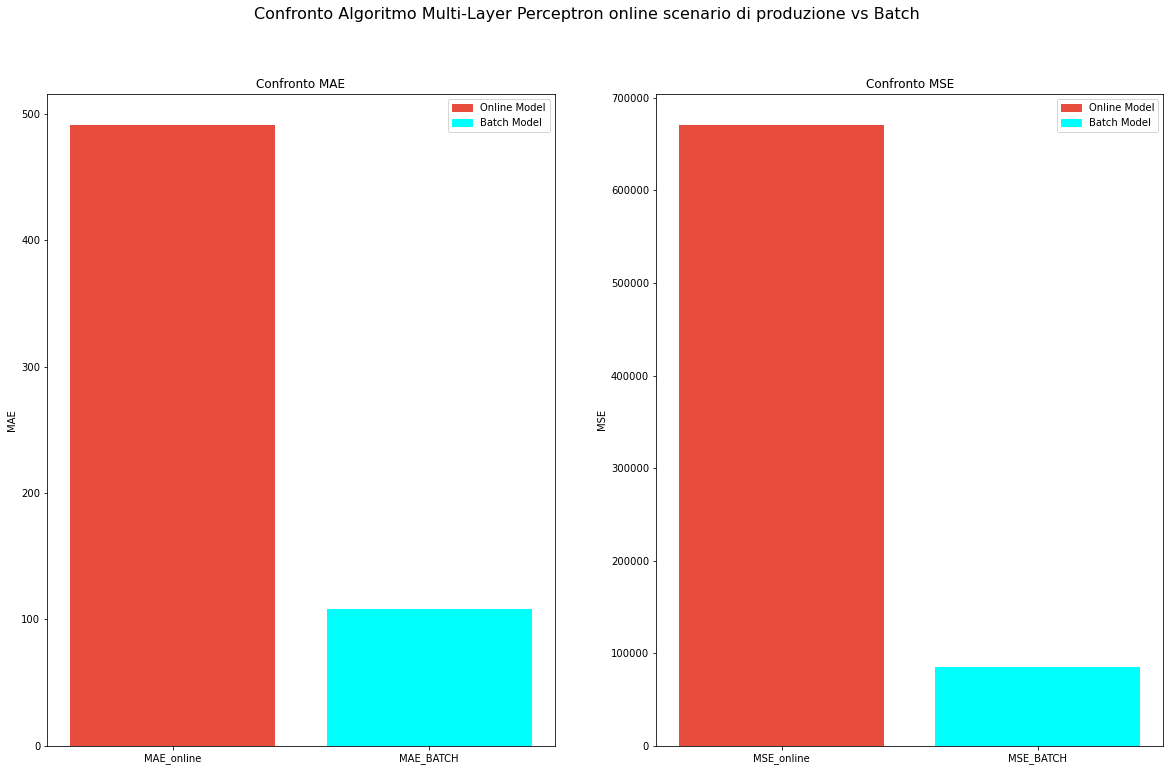

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Multi-Layer Perceptron online scenario di produzione vs Batch',  fontsize=16)

ax1.bar(height=[491.27877,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[671038.020694,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

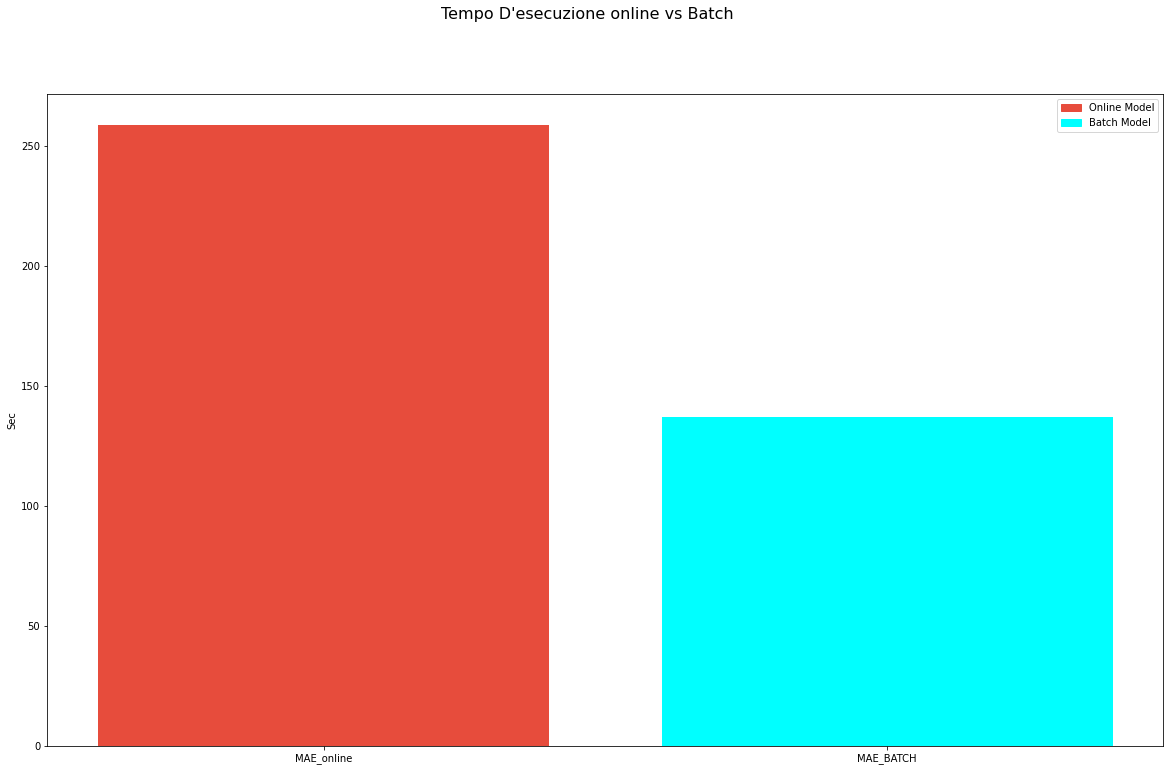

In [44]:


fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[258.9142005,137.245078], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

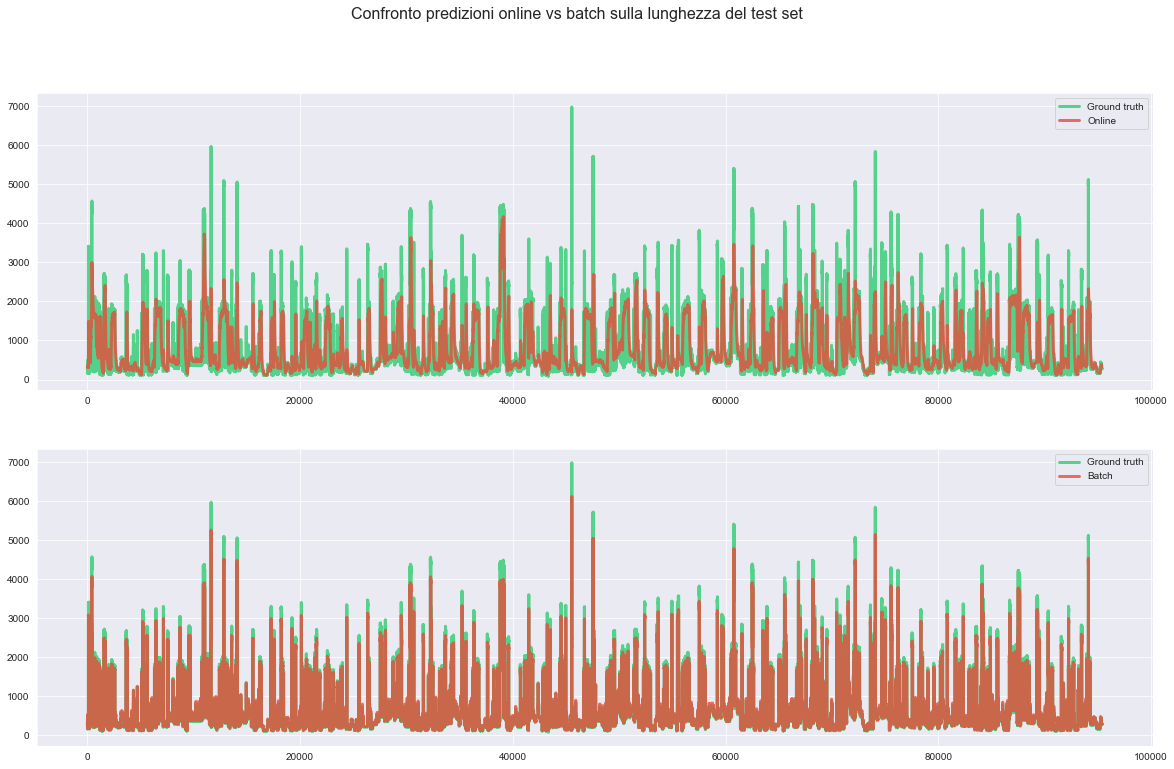

In [6]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_mlp, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_ml_online[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## KNN Regressor Batch vs Online


### KNN regressor Online


100%|██████████| 318000/318000 [01:07<00:00, 4729.54it/s]


Execution time: 67.23948860168457 seconds


Text(0.5, 1.0, 'MSE: 738,435.337979')

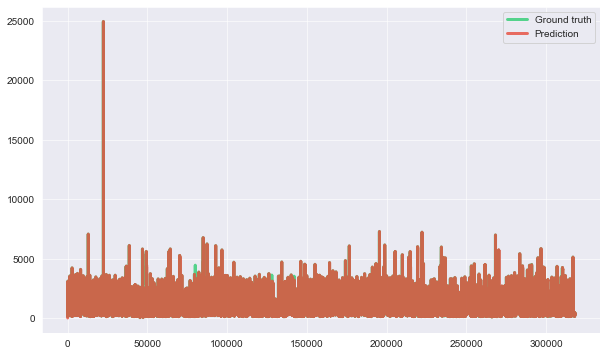

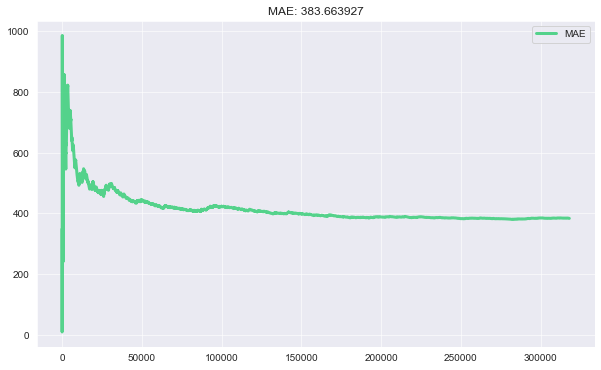

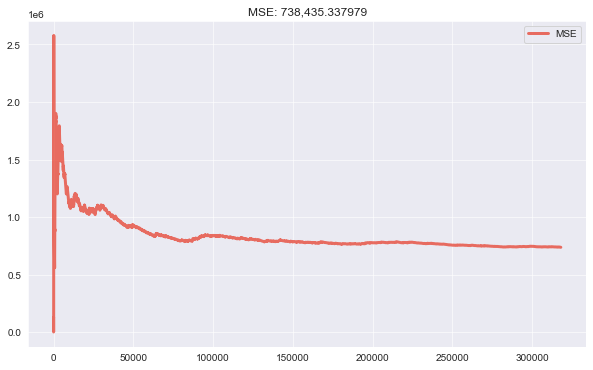

In [7]:

metric_mae_knnreg = metrics.MAE()
metric_mse_knnreg = metrics.MSE()

dates_knnreg = []
y_trues_knnreg = []
y_preds_knnreg = []
metrics_MAE_knnreg = []
metrics_MSE_knnreg = []

X_y = initial_iter_twe()

model = compose.Select( 'Count_days')
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=5
)

# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #318000
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go

       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_knnreg.update(y, y_pred)
       metric_mse_knnreg.update(y, y_pred)
       metrics_MAE_knnreg.append(metric_mae_knnreg.get())
       metrics_MSE_knnreg.append(metric_mse_knnreg.get())


       # Store the true value and the prediction
       dates_knnreg.append(i)
       y_trues_knnreg.append(y)
       y_preds_knnreg.append(y_pred)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, y_trues_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_knnreg, y_preds_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MAE_knnreg, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_knnreg)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_knnreg, metrics_MSE_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_knnreg)

In [49]:
X_y = initial_iter_twe()

model = compose.Select( 'Count_days')
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=5
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       delay=83,
       print_every=3000
)

[3,000] MAE: 646.8868
[6,000] MAE: 590.180033
[9,000] MAE: 540.924067
[12,000] MAE: 539.455583
[15,000] MAE: 563.003267
[18,000] MAE: 560.875578
[21,000] MAE: 548.7972
[24,000] MAE: 552.502017
[27,000] MAE: 563.043126
[30,000] MAE: 568.533133
[33,000] MAE: 562.448648
[36,000] MAE: 548.057906
[39,000] MAE: 551.173795
[42,000] MAE: 542.190167
[45,000] MAE: 542.283724
[48,000] MAE: 547.638896
[51,000] MAE: 555.354255
[54,000] MAE: 549.01543
[57,000] MAE: 550.044211
[60,000] MAE: 542.11614
[63,000] MAE: 544.993968
[66,000] MAE: 552.922842
[69,000] MAE: 555.756278
[72,000] MAE: 556.150864
[75,000] MAE: 550.013984
[78,000] MAE: 546.754644
[81,000] MAE: 550.164726
[84,000] MAE: 544.039033
[87,000] MAE: 546.33303
[90,000] MAE: 548.234887
[93,000] MAE: 560.897019
[96,000] MAE: 559.282885
[99,000] MAE: 558.972667
[102,000] MAE: 561.268408
[105,000] MAE: 561.847526
[108,000] MAE: 560.014452
[111,000] MAE: 556.186584
[114,000] MAE: 550.109784
[117,000] MAE: 548.144862
[120,000] MAE: 544.306007
[12

MAE: 532.925391

In [50]:
X_y = initial_iter_twe()

model = compose.Select( 'Count_days')
model |= neighbors.KNNRegressor(
       window_size= 50,
       n_neighbors=5
)

evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MSE(),
       delay=83,
       print_every=3000
)

[3,000] MSE: 1,312,449.656533
[6,000] MSE: 1,220,267.092273
[9,000] MSE: 1,112,457.853196
[12,000] MSE: 1,100,805.24949
[15,000] MSE: 1,176,514.831757
[18,000] MSE: 1,163,505.581738
[21,000] MSE: 1,132,331.0832
[24,000] MSE: 1,175,084.442587
[27,000] MSE: 1,193,553.739896
[30,000] MSE: 1,197,782.001027
[33,000] MSE: 1,175,178.914913
[36,000] MSE: 1,124,302.246837
[39,000] MSE: 1,127,637.158277
[42,000] MSE: 1,095,601.18353
[45,000] MSE: 1,083,551.823063
[48,000] MSE: 1,084,203.265822
[51,000] MSE: 1,110,542.942553
[54,000] MSE: 1,086,576.497784
[57,000] MSE: 1,077,761.708789
[60,000] MSE: 1,048,875.741392
[63,000] MSE: 1,051,812.395218
[66,000] MSE: 1,078,177.401919
[69,000] MSE: 1,075,541.063511
[72,000] MSE: 1,076,471.716577
[75,000] MSE: 1,055,675.232572
[78,000] MSE: 1,037,322.829942
[81,000] MSE: 1,040,883.88266
[84,000] MSE: 1,029,113.978332
[87,000] MSE: 1,039,715.842092
[90,000] MSE: 1,051,143.307448
[93,000] MSE: 1,081,276.246139
[96,000] MSE: 1,077,785.657056
[99,000] MSE: 1,

MSE: 1,000,965.580079

### KNN regressor Batch

In [8]:
X_knm = dati_complete_twe['PowerConsumption'].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_knm, y_knm = split_sequence(X_knm, 1)

X_train_knm, X_test_knm, Y_train_knm, Y_test_knm = train_test_split(X_knm, y_knm, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_knm, Y_train_knm)

result_knnreg = neigh.predict(X_test_knm)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.8019146919250488 seconds


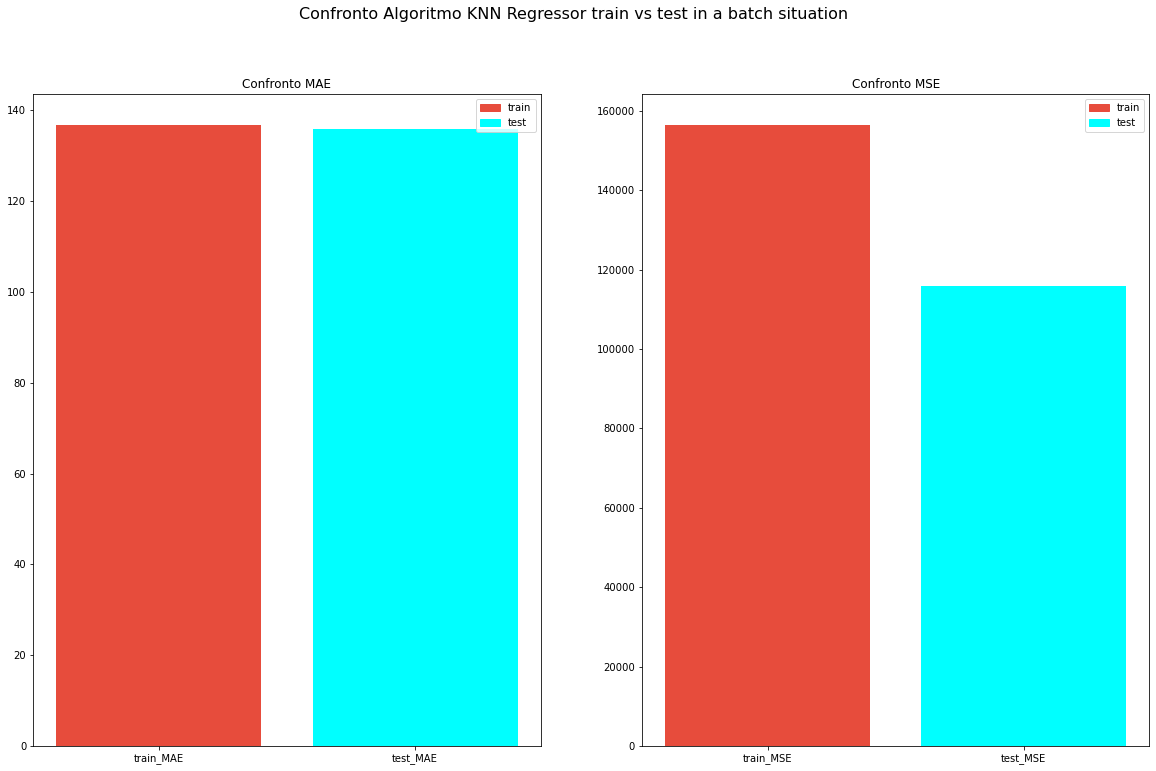

In [56]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_knm, neigh.predict(X_train_knm)),mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_knm, neigh.predict(X_train_knm)),mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

In [58]:
len(Y_test_knm)

95400

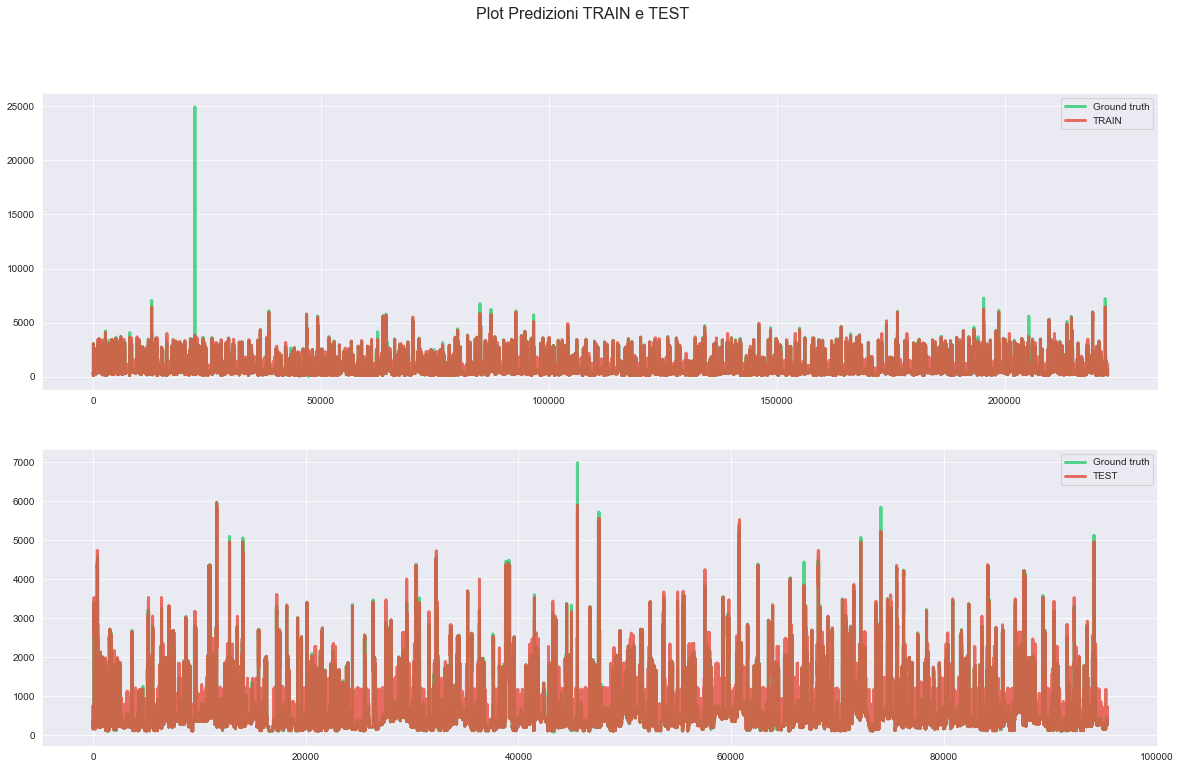

In [9]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Plot Predizioni TRAIN e TEST',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(neigh.predict(X_train_knm), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(neigh.predict(X_test_knm), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto KNN regressor Batch vs KNN regressor Online


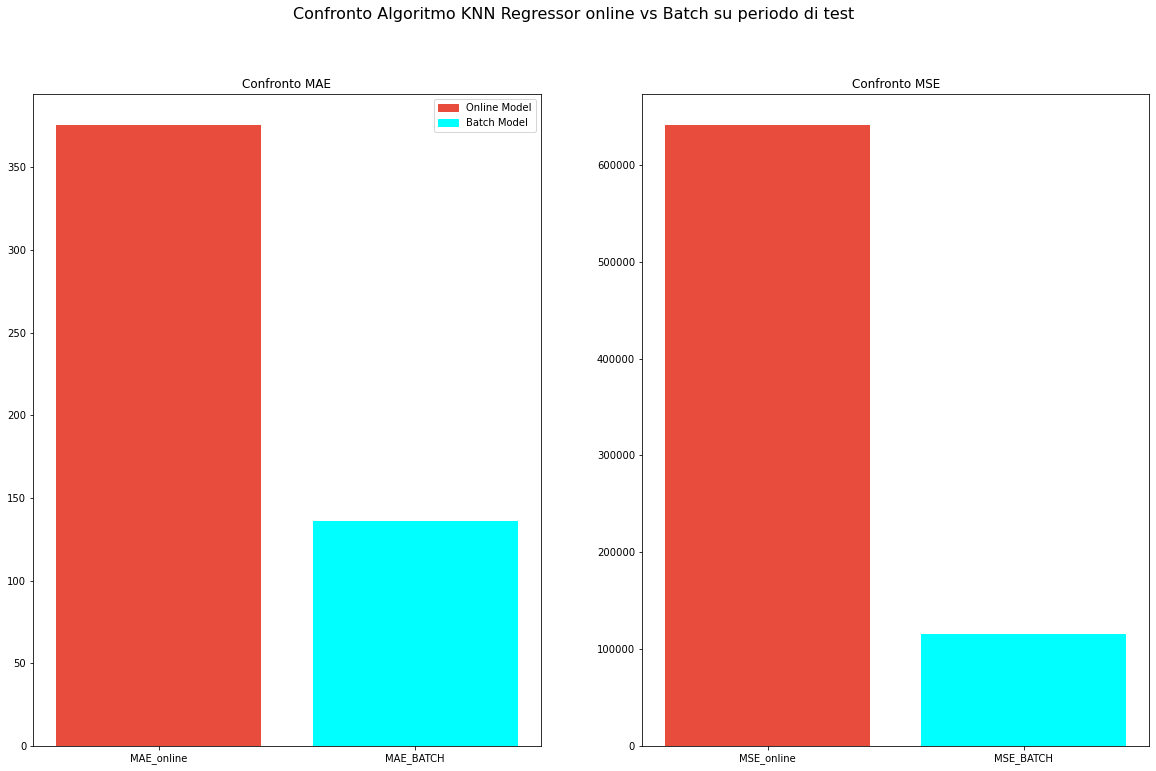

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_knm, y_preds_knnreg[-95400::]),mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_knm, y_preds_knnreg[-95400::]),mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])

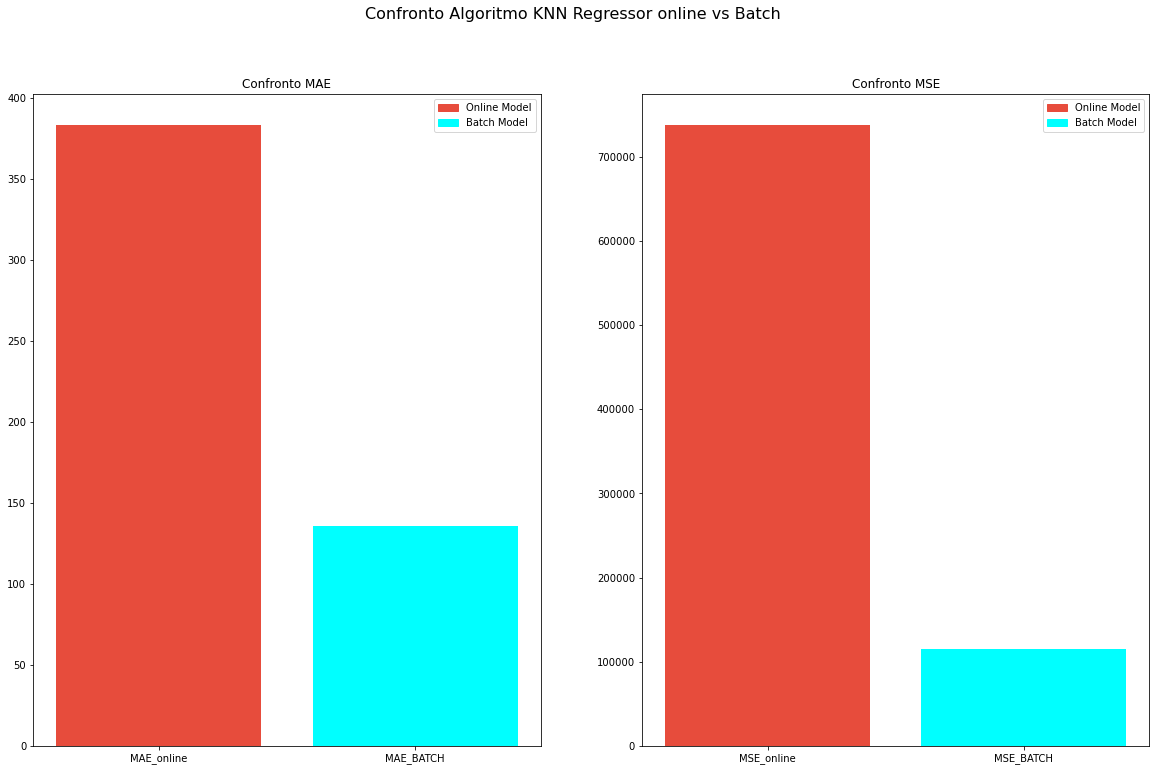

In [63]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN Regressor online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_knnreg[-1],mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_knnreg[-1],mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

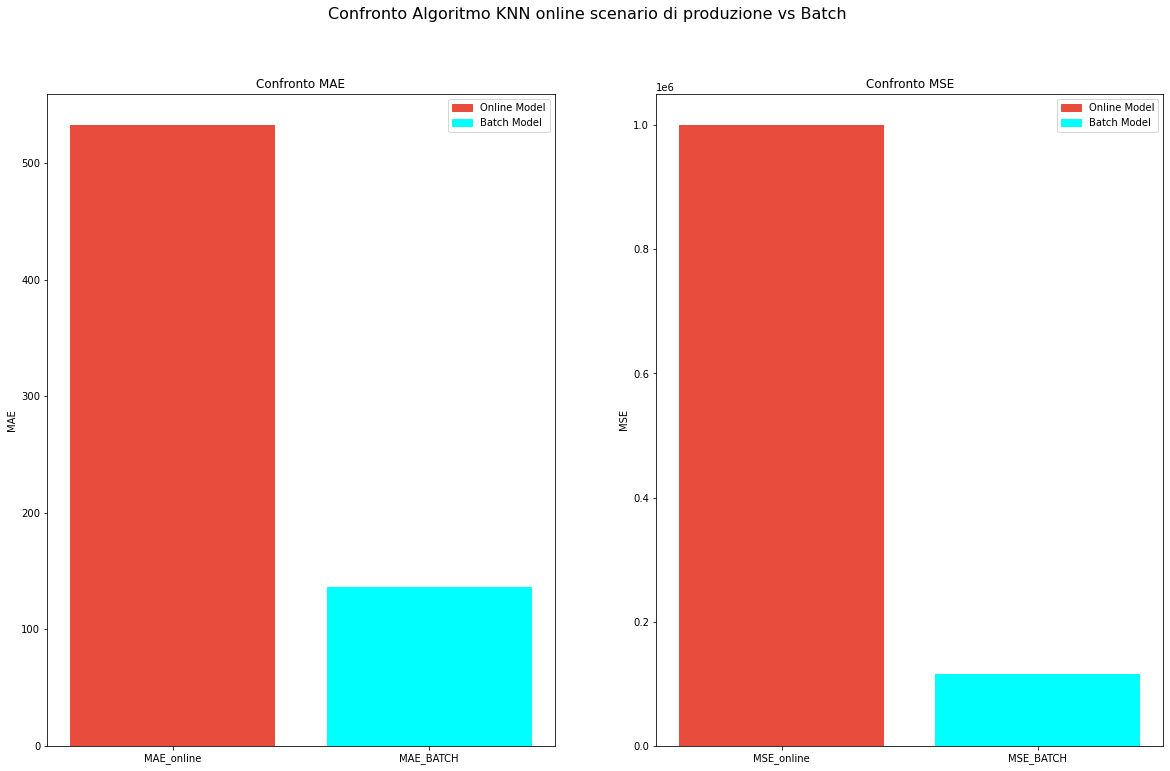

In [65]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo KNN online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[532.925391, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[1000965.850079, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

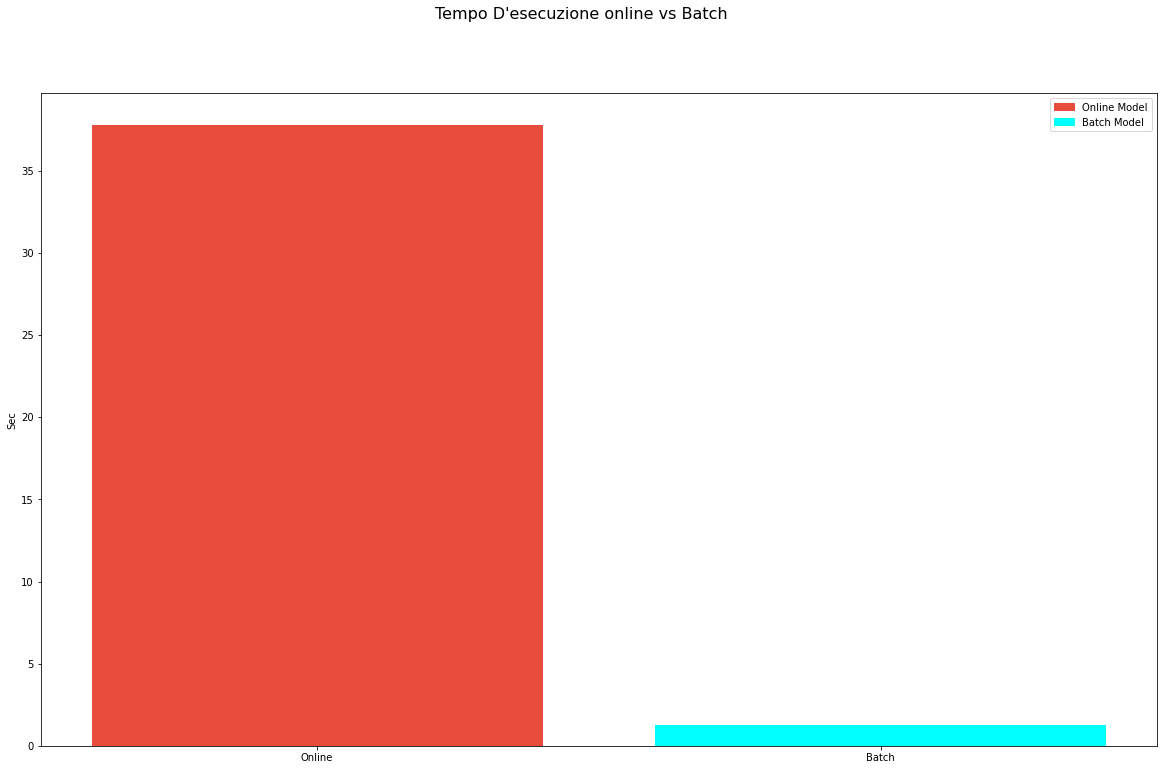

In [66]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[37.82279, 1.249962], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

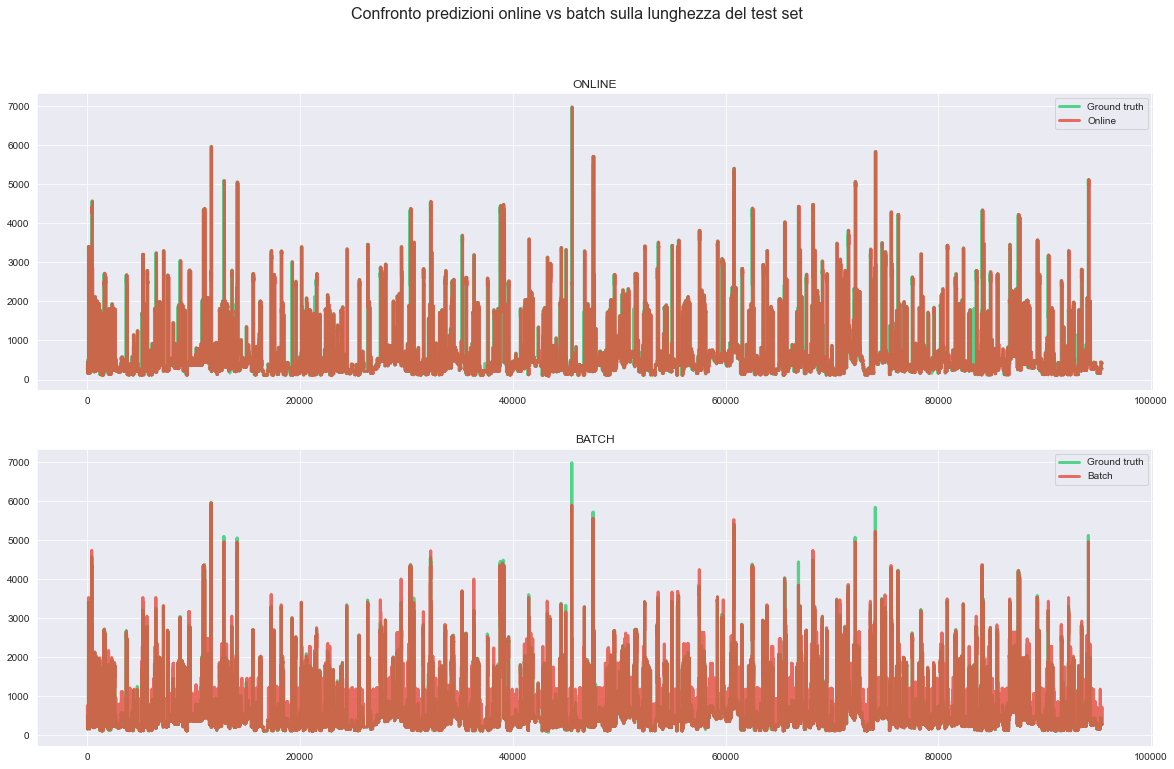

In [10]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_knm, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_knnreg[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Random Forest Online vs Random Forest Batch


### Random Forest Online


100%|██████████| 318000/318000 [03:35<00:00, 1472.87it/s]


Execution time: 215.90798807144165 seconds


Text(0.5, 1.0, 'MSE: 196,583.462658')

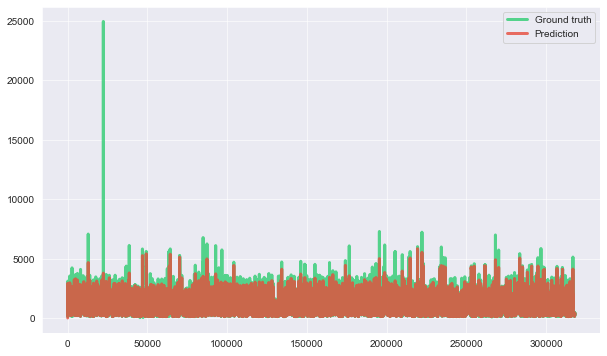

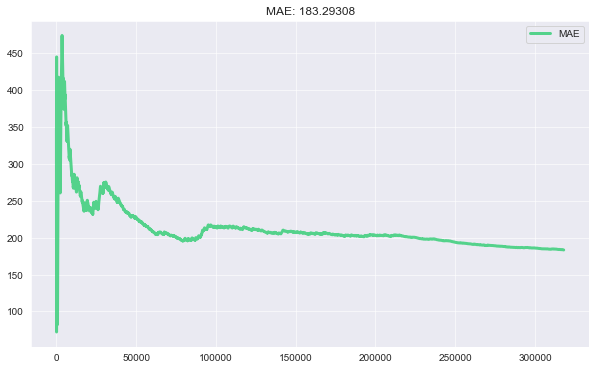

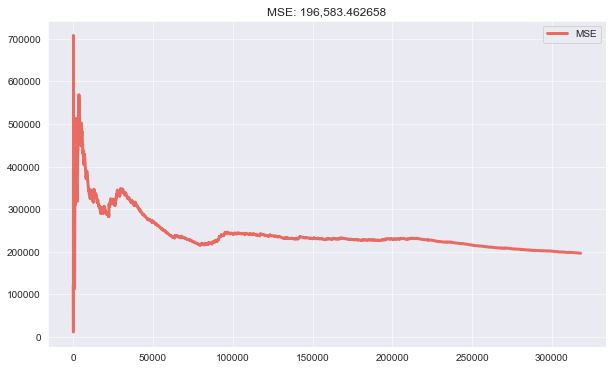

In [11]:

metric_mae_ranFor_on = metrics.MAE()
metric_mse_ranFor_on = metrics.MSE()

dates_ranFor_on = []
y_trues_ranFor_on = []
y_preds_ranFor_on = []
metrics_MAE_ranFor_on = []
metrics_MSE_ranFor_on = []

X_y = initial_iter_twe()

model = compose.Select()
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(
       n_models=3,
       grace_period=20,
       max_depth=20
)


# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #318000
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_ranFor_on.update(y, y_pred)
       metric_mse_ranFor_on.update(y, y_pred)
       metrics_MAE_ranFor_on.append(metric_mae_ranFor_on.get())
       metrics_MSE_ranFor_on.append(metric_mse_ranFor_on.get())

       # Store the true value and the prediction
       dates_ranFor_on.append(i)
       y_trues_ranFor_on.append(y)
       y_preds_ranFor_on.append(y_pred)


et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, y_trues_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_ranFor_on, y_preds_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MAE_ranFor_on, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_ranFor_on)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_ranFor_on, metrics_MSE_ranFor_on, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_ranFor_on)

In [69]:
X_y = initial_iter_twe()

model = compose.Select()
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(
       n_models=3,
       grace_period=20,
       max_depth=20
)


evaluate.progressive_val_score(
       dataset=X_y,
       model=model,
       metric=metrics.MAE(),
       delay=83,
       print_every=3000
)

[3,000] MAE: 702.974366
[6,000] MAE: 642.322031
[9,000] MAE: 568.212875
[12,000] MAE: 550.576818
[15,000] MAE: 557.588794
[18,000] MAE: 542.742677
[21,000] MAE: 527.047412
[24,000] MAE: 536.094518
[27,000] MAE: 540.987964
[30,000] MAE: 545.227514
[33,000] MAE: 537.719711
[36,000] MAE: 520.813405
[39,000] MAE: 520.425528
[42,000] MAE: 506.169556
[45,000] MAE: 507.269744
[48,000] MAE: 507.201404
[51,000] MAE: 509.337271
[54,000] MAE: 502.087466
[57,000] MAE: 500.166199
[60,000] MAE: 492.427855
[63,000] MAE: 489.720852
[66,000] MAE: 493.869213
[69,000] MAE: 496.390736
[72,000] MAE: 494.044695
[75,000] MAE: 491.119615
[78,000] MAE: 486.617237
[81,000] MAE: 491.478757
[84,000] MAE: 486.28588
[87,000] MAE: 487.168457
[90,000] MAE: 491.223851
[93,000] MAE: 501.538238
[96,000] MAE: 500.332584
[99,000] MAE: 499.076085
[102,000] MAE: 500.962978
[105,000] MAE: 502.82635
[108,000] MAE: 501.129598
[111,000] MAE: 497.725404
[114,000] MAE: 492.202377
[117,000] MAE: 490.556615
[120,000] MAE: 485.19975

MAE: 465.407756

In [70]:
X_y = initial_iter_twe()

model = compose.Select()
model |= preprocessing.StandardScaler()
model |= ensemble.AdaptiveRandomForestRegressor(
       n_models=3,
       grace_period=20,
       max_depth=20
)


evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=83,
       print_every=3000
)

[3,000] MSE: 1,160,393.90329
[6,000] MSE: 1,053,518.562473
[9,000] MSE: 935,142.302235
[12,000] MSE: 916,459.750996
[15,000] MSE: 964,272.241528
[18,000] MSE: 932,003.229939
[21,000] MSE: 899,368.261441
[24,000] MSE: 934,721.32202
[27,000] MSE: 933,271.538483
[30,000] MSE: 919,431.622479
[33,000] MSE: 899,696.525769
[36,000] MSE: 859,603.945475
[39,000] MSE: 860,937.38587
[42,000] MSE: 831,737.708626
[45,000] MSE: 829,526.419178
[48,000] MSE: 826,569.668953
[51,000] MSE: 844,278.587516
[54,000] MSE: 826,706.166303
[57,000] MSE: 819,298.15726
[60,000] MSE: 797,715.680654
[63,000] MSE: 793,798.931518
[66,000] MSE: 806,171.422286
[69,000] MSE: 804,647.419669
[72,000] MSE: 804,166.339405
[75,000] MSE: 793,330.557671
[78,000] MSE: 778,467.084611
[81,000] MSE: 787,358.664391
[84,000] MSE: 777,896.979994
[87,000] MSE: 783,427.143138
[90,000] MSE: 793,745.479366
[93,000] MSE: 807,873.865383
[96,000] MSE: 802,756.146119
[99,000] MSE: 801,035.733137
[102,000] MSE: 804,949.574436
[105,000] MSE: 8

MSE: 741,782.972241

### Random Forest Batch


In [12]:
X_RF = dati_complete_twe['PowerConsumption'].to_numpy()
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# split into samples
X_RF, y_RF = split_sequence(X_RF, 1)



In [13]:
X_train_RF, X_test_RF, Y_train_RF, Y_test_RF = train_test_split(X_RF, y_RF, random_state=1, train_size=0.7, shuffle=False)

In [14]:

# get the start time
st = time.time()

regr_random_forest = RandomForestRegressor(max_depth=25, random_state=0).fit(X_train_RF, Y_train_RF)
result_random_forest = regr_random_forest.predict(X_test_RF).reshape(-1,1)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 13.2203950881958 seconds


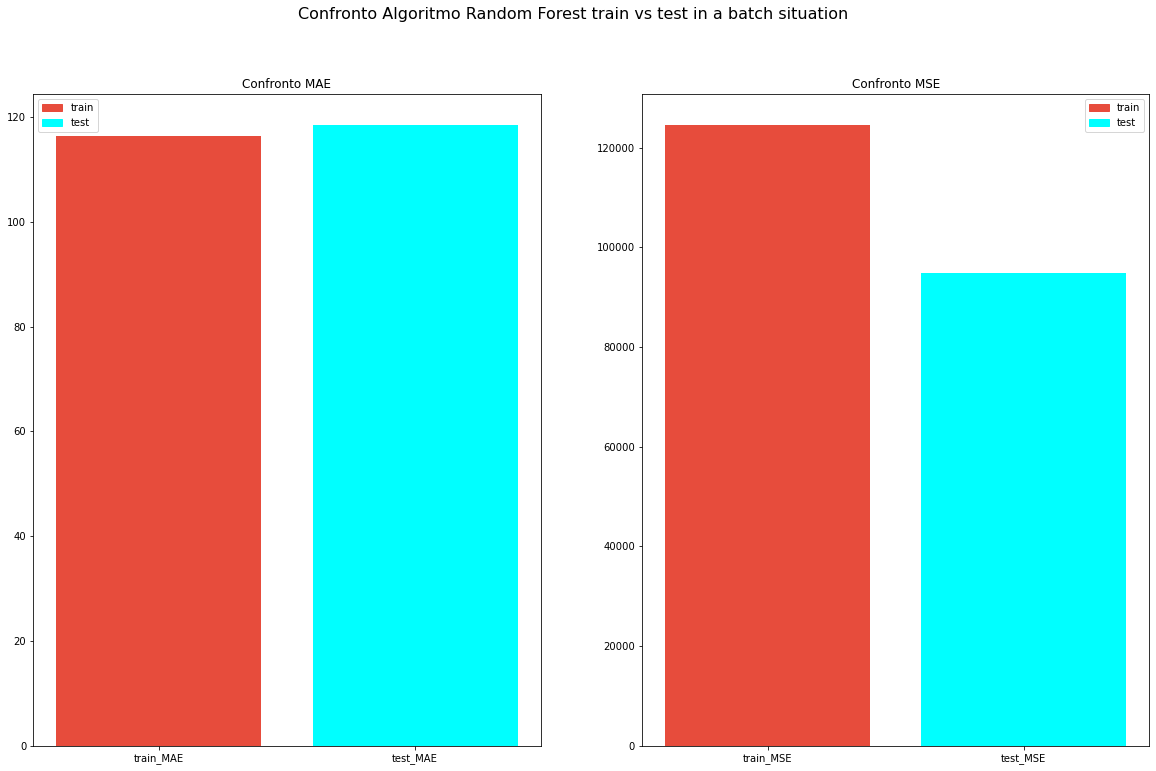

In [74]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_RF, regr_random_forest.predict(X_train_RF)),mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_RF, regr_random_forest.predict(X_train_RF)),mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

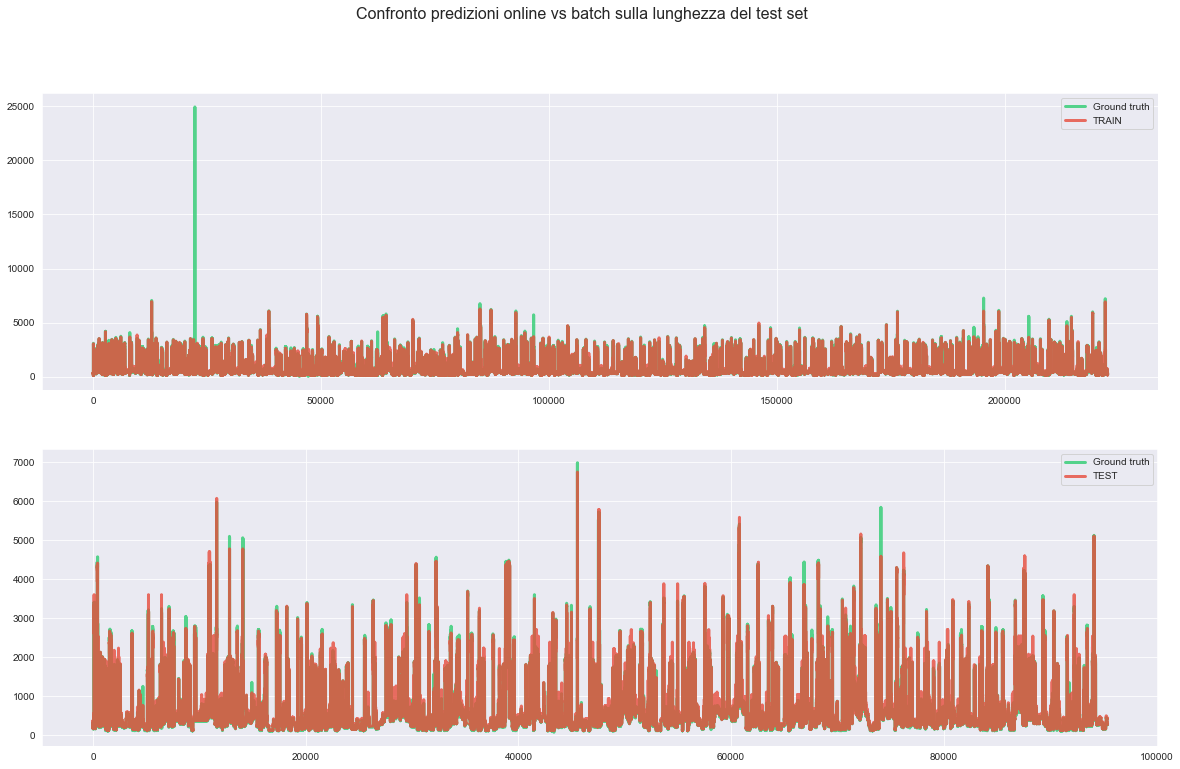

In [15]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(regr_random_forest.predict(X_train_RF), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(regr_random_forest.predict(X_test_RF), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto Random Forest Batch vs Random Forest Online


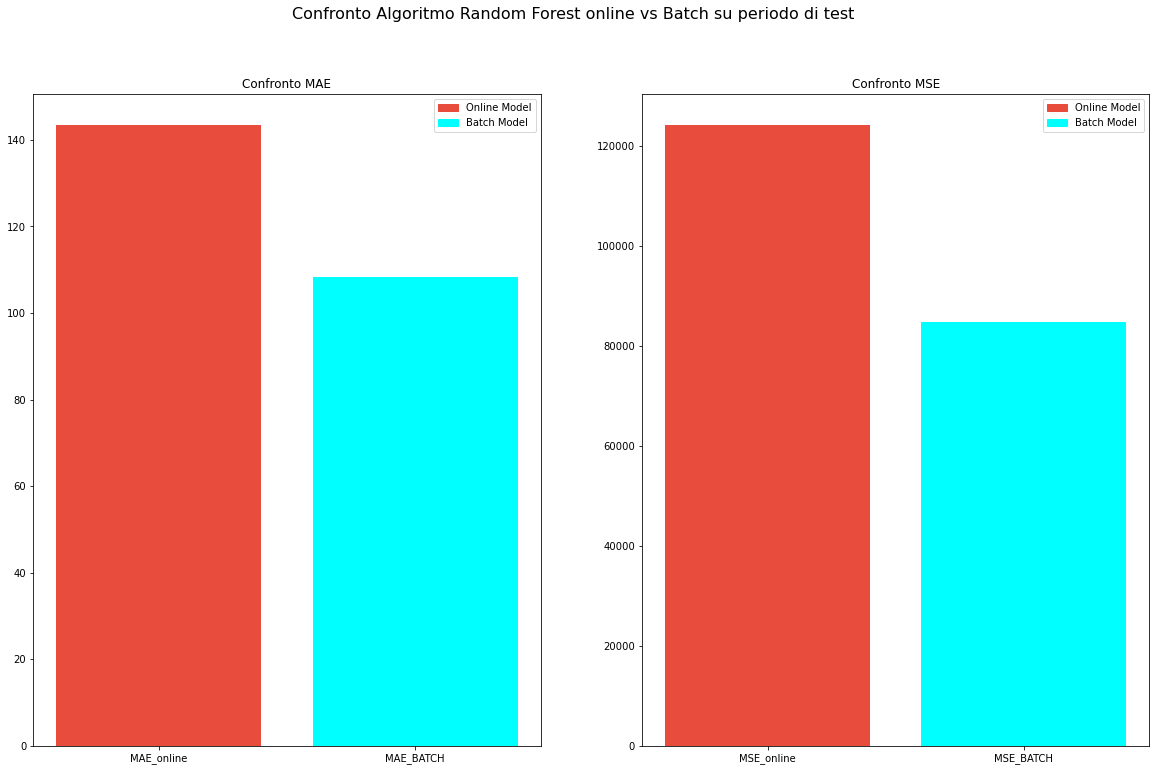

In [77]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online vs Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-95400::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_RF, y_preds_ranFor_on[-95400::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

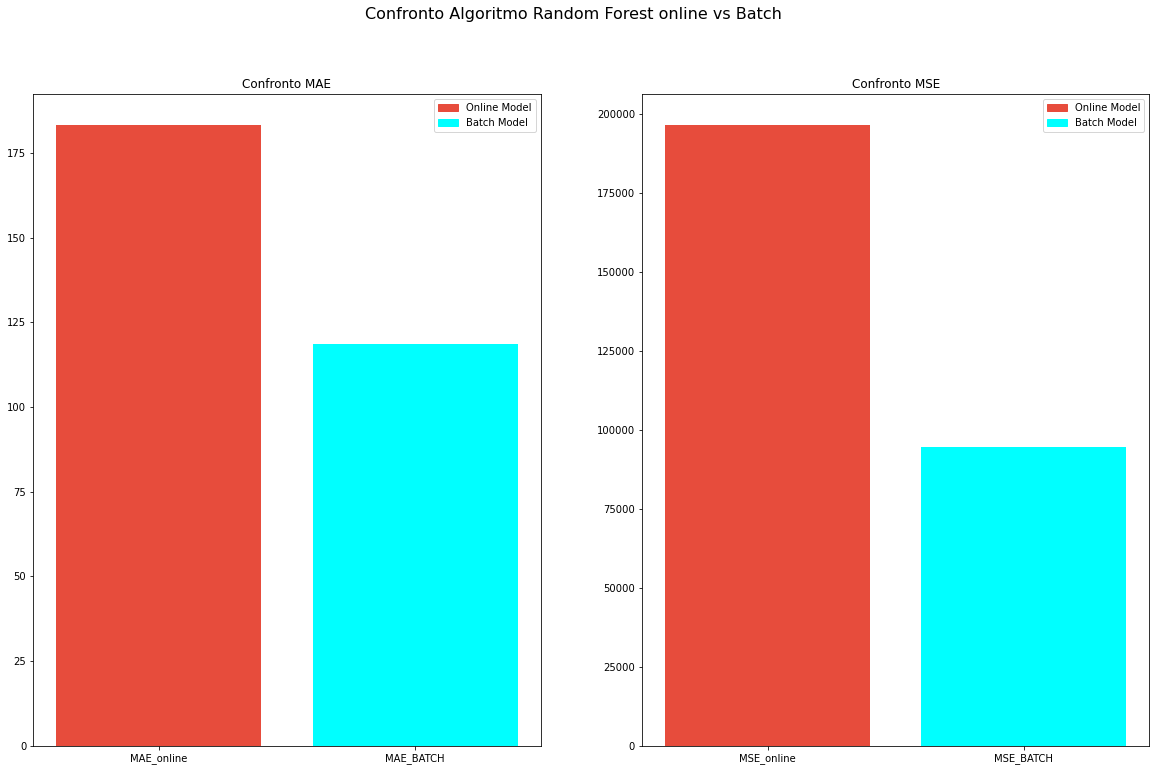

In [78]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online vs Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

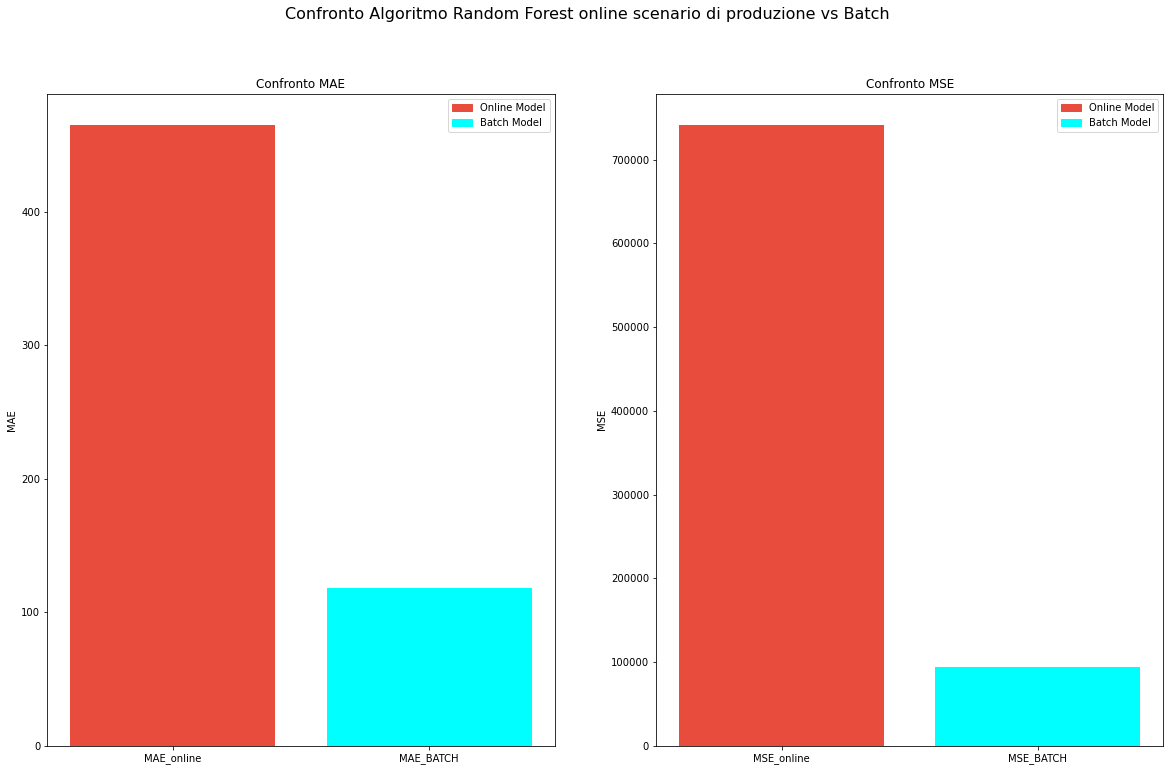

In [79]:
ax2.set_title('Confronto MSE')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Random Forest online scenario di produzione vs Batch', fontsize=16)

ax1.bar(height=[465.407756, mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MAE_online', 'MAE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[741728.972241, mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF))], x=['MSE_online', 'MSE_BATCH'],
        color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

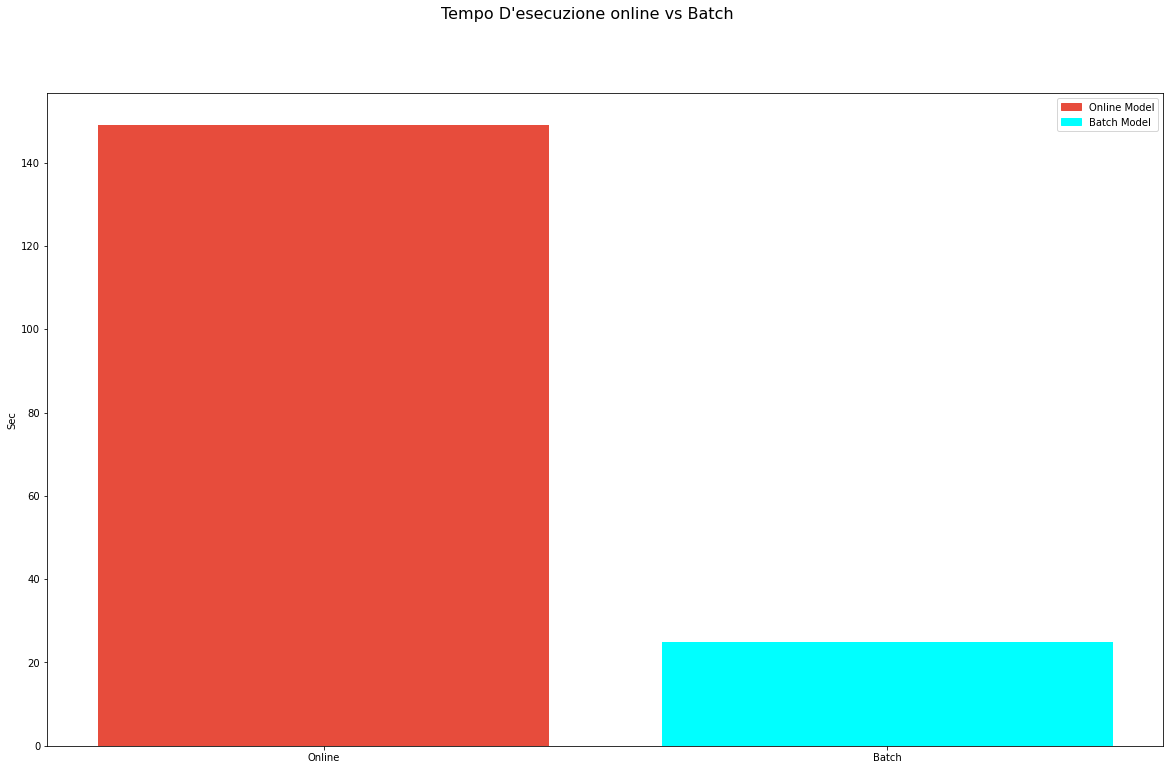

In [80]:
fig, ax = plt.subplots(figsize=(20, 12))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[149.1518952, 24.89266157], x=['Online','Batch'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

Text(0.5, 1.0, 'BATCH')

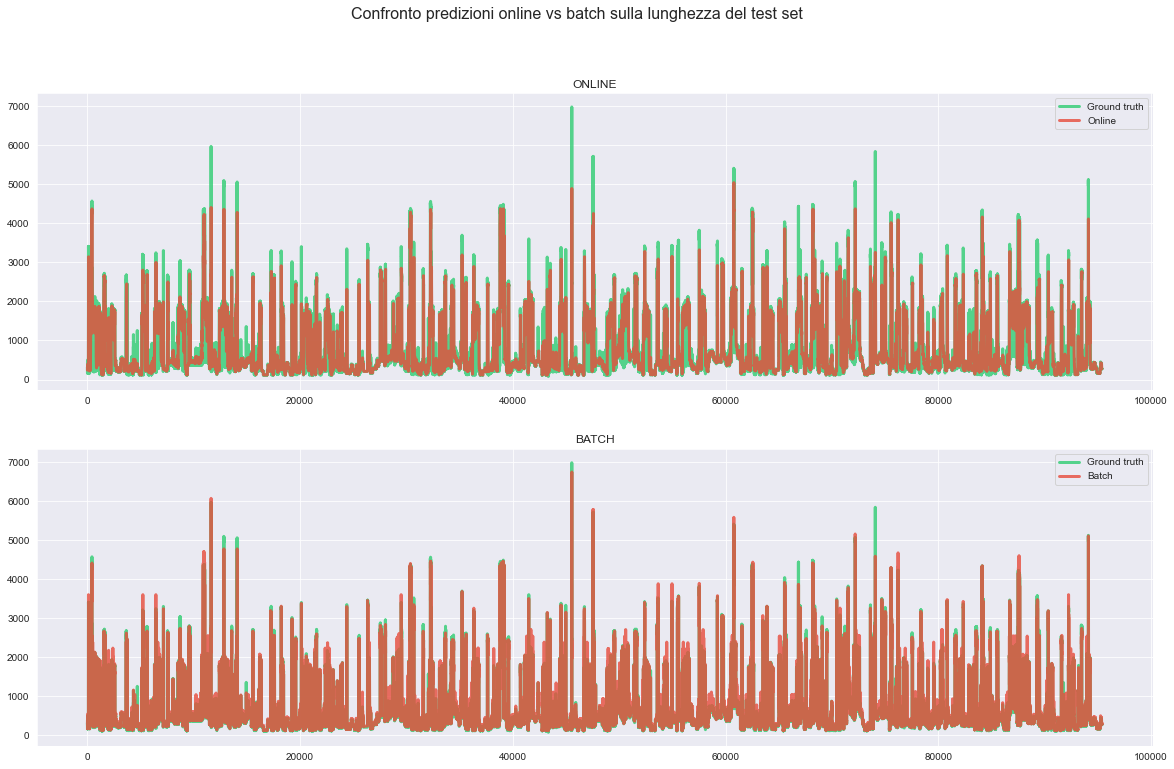

In [16]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_RF, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_ranFor_on[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()
ax1.set_title('ONLINE')
ax2.set_title('BATCH')

## Decision Tree Online vs Decision Tree Batch


### Decision Tree Online


100%|██████████| 318000/318000 [00:31<00:00, 10108.96it/s]


Execution time: 31.46110248565674 seconds


Text(0.5, 1.0, 'MSE: 299,409.701092')

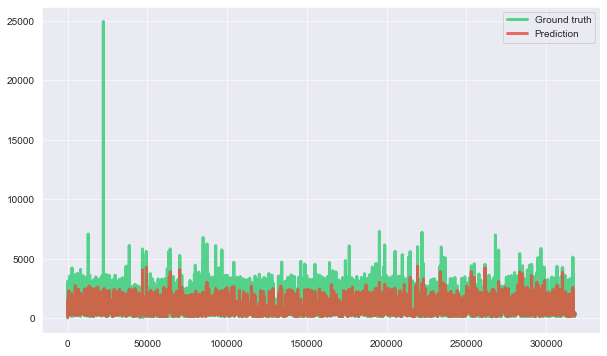

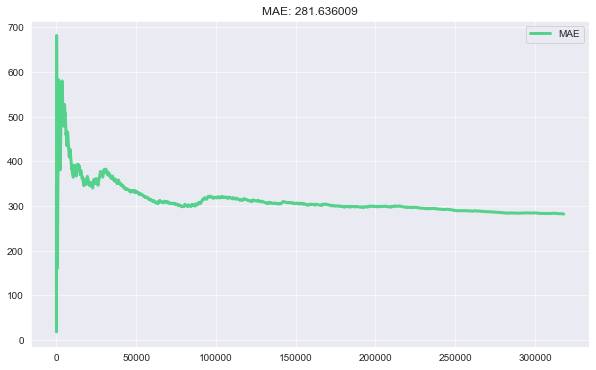

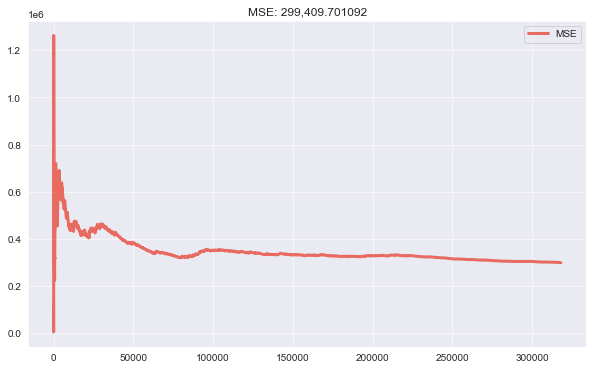

In [17]:
metric_mae_dec_tree = metrics.MAE()
metric_mse_dec_tree = metrics.MSE()

dates_dec_tree = []
y_trues_dec_tree = []
y_preds_dec_tree = []
metrics_MAE_dec_tree = []
metrics_MSE_dec_tree = []

X_y = initial_iter_twe()

model = compose.Select( )
model |= tree.HoeffdingAdaptiveTreeRegressor(
       grace_period=20,
       leaf_prediction='adaptive',
       min_samples_split=30
       )

# get the start time
st = time.time()

for i in tqdm(range(0,318000)):  #8496
       x, y = next(X_y)
       # Obtain the prior prediction and update the model in one go
       y_pred = model.predict_one(x)
       model.learn_one(x, y)

       # Update the error metric
       metric_mae_dec_tree.update(y, y_pred)
       metric_mse_dec_tree.update(y, y_pred)
       metrics_MAE_dec_tree.append(metric_mae_dec_tree.get())
       metrics_MSE_dec_tree.append(metric_mse_dec_tree.get())

       # Store the true value and the prediction
       dates_dec_tree.append(i)
       y_trues_dec_tree.append(y)
       y_preds_dec_tree.append(y_pred)

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, y_trues_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates_dec_tree, y_preds_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MAE_dec_tree, lw=3, color='#2ecc71', alpha=0.8, label='MAE')
ax.legend()
ax.set_title(metric_mae_dec_tree)


fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates_dec_tree, metrics_MSE_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='MSE')
ax.legend()
ax.set_title(metric_mse_dec_tree)

In [83]:
X_y = initial_iter_twe()

model = compose.Select( )
model |= tree.HoeffdingAdaptiveTreeRegressor(
       grace_period=20,
       leaf_prediction='adaptive',
       min_samples_split=30
       )

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MAE(),
       delay=83,
       print_every=3000
)

[3,000] MAE: 653.329265
[6,000] MAE: 612.352955
[9,000] MAE: 552.921244
[12,000] MAE: 543.067375
[15,000] MAE: 548.246476
[18,000] MAE: 537.953555
[21,000] MAE: 521.111113
[24,000] MAE: 528.026713
[27,000] MAE: 534.651942
[30,000] MAE: 541.987194
[33,000] MAE: 534.861244
[36,000] MAE: 519.423852
[39,000] MAE: 519.565158
[42,000] MAE: 508.496826
[45,000] MAE: 509.066936
[48,000] MAE: 510.104307
[51,000] MAE: 514.523811
[54,000] MAE: 507.412351
[57,000] MAE: 506.379433
[60,000] MAE: 498.788219
[63,000] MAE: 498.448687
[66,000] MAE: 502.922011
[69,000] MAE: 505.436196
[72,000] MAE: 504.156102
[75,000] MAE: 500.552431
[78,000] MAE: 496.329238
[81,000] MAE: 500.569436
[84,000] MAE: 495.034445
[87,000] MAE: 495.463639
[90,000] MAE: 498.972498
[93,000] MAE: 508.84643
[96,000] MAE: 506.712146
[99,000] MAE: 506.616579
[102,000] MAE: 508.10827
[105,000] MAE: 509.548434
[108,000] MAE: 507.925054
[111,000] MAE: 504.244058
[114,000] MAE: 498.581294
[117,000] MAE: 497.017153
[120,000] MAE: 492.09744

MAE: 474.593744

In [84]:
X_y = initial_iter_twe()

model = compose.Select( )
model |= tree.HoeffdingAdaptiveTreeRegressor(
       grace_period=20,
       leaf_prediction='adaptive',
       min_samples_split=30
       )

evaluate.progressive_val_score(
       dataset= X_y,
       model = model,
       metric = metrics.MSE(),
       delay=83,
       print_every=3000
)

[3,000] MSE: 938,364.213826
[6,000] MSE: 878,097.346235
[9,000] MSE: 792,375.15442
[12,000] MSE: 784,394.370311
[15,000] MSE: 815,888.446246
[18,000] MSE: 799,658.018988
[21,000] MSE: 769,629.498203
[24,000] MSE: 796,521.119321
[27,000] MSE: 801,741.339063
[30,000] MSE: 796,628.023254
[33,000] MSE: 781,014.119264
[36,000] MSE: 747,977.436171
[39,000] MSE: 747,402.016577
[42,000] MSE: 727,503.529749
[45,000] MSE: 724,415.698832
[48,000] MSE: 723,266.193589
[51,000] MSE: 745,909.654282
[54,000] MSE: 729,737.473757
[57,000] MSE: 725,448.533425
[60,000] MSE: 706,736.421188
[63,000] MSE: 709,337.285248
[66,000] MSE: 724,076.603378
[69,000] MSE: 722,602.525297
[72,000] MSE: 725,778.544476
[75,000] MSE: 714,248.358709
[78,000] MSE: 702,201.177167
[81,000] MSE: 706,876.385949
[84,000] MSE: 697,509.790046
[87,000] MSE: 701,471.295338
[90,000] MSE: 706,563.535689
[93,000] MSE: 718,116.560887
[96,000] MSE: 713,348.335426
[99,000] MSE: 713,699.031424
[102,000] MSE: 717,109.529427
[105,000] MSE: 72

MSE: 668,359.015795

### Decision Tree Batch


In [18]:
X_DT = dati_complete_twe['PowerConsumption'].to_numpy()


def split_sequence(sequence, n_steps):
       X, y = list(), list()
       for i in range(len(sequence)):
              # find the end of this pattern
              end_ix = i + n_steps
              # check if we are beyond the sequence
              if end_ix > len(sequence) - 1:
                     break
              # gather input and output parts of the pattern
              seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
              X.append(seq_x)
              y.append(seq_y)
       return X, y


# split into samples
X_DT, y_DT = split_sequence(X_DT, 1)

X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_DT, y_DT, random_state=1, train_size=0.7, shuffle=False)

# get the start time
st = time.time()

regressor_dec_tree = DecisionTreeRegressor(random_state=0, max_depth=7).fit(X_train_DT, Y_train_DT)

result_dec_tree = regressor_dec_tree.predict(X_test_DT)

et = time.time()

# get the execution time

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 0.9775073528289795 seconds


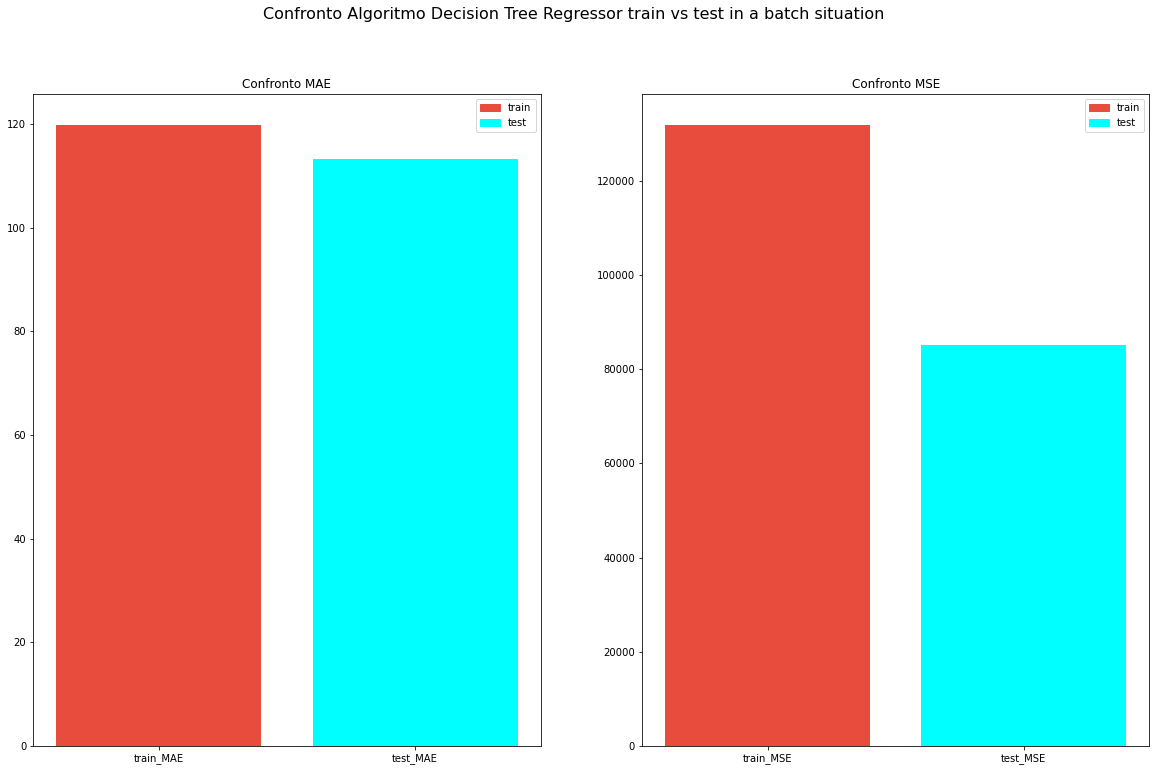

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Decision Tree Regressor train vs test in a batch situation',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_train_DT, regressor_dec_tree.predict(X_train_DT)),mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['train_MAE','test_MAE'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_train_DT, regressor_dec_tree.predict(X_train_DT)),mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['train_MSE','test_MSE'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='train')
cyan_patch= mpatches.Patch(color='cyan', label='test')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

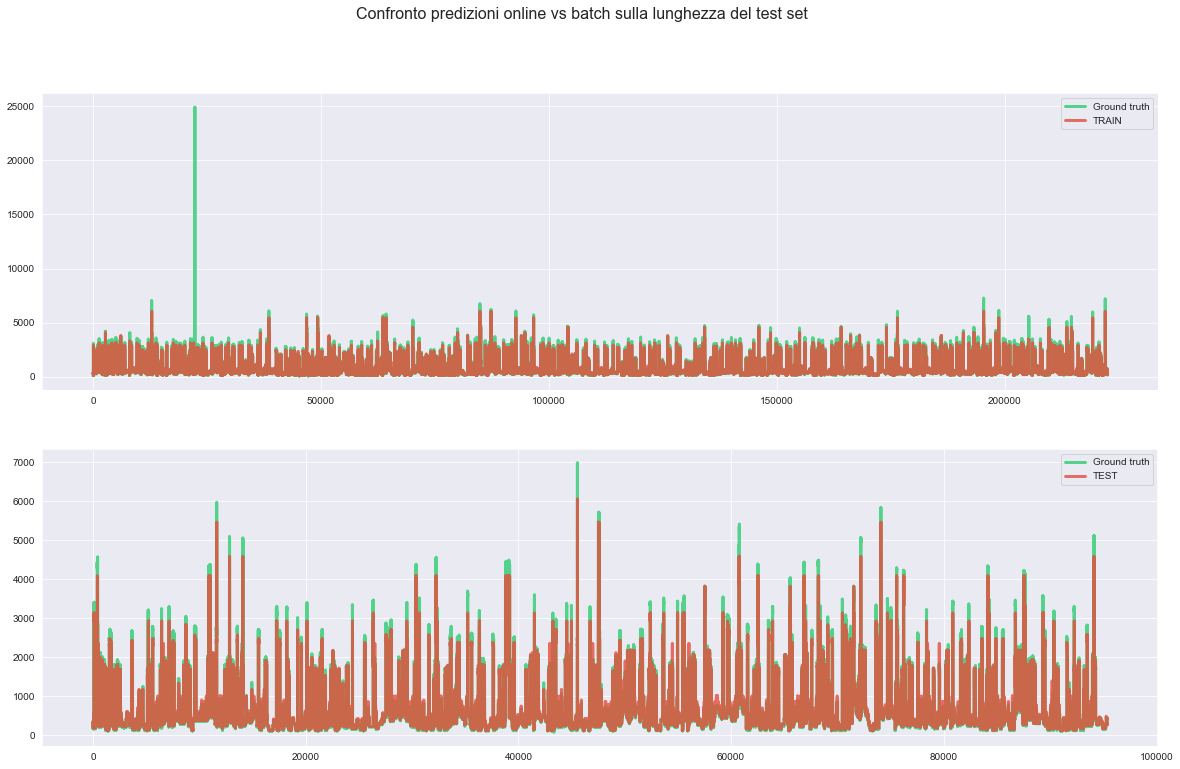

In [19]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_train_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(regressor_dec_tree.predict(X_train_DT), lw=3, color='#e74c3c', alpha=0.8, label='TRAIN')
ax2.plot(regressor_dec_tree.predict(X_test_DT), lw=3, color='#e74c3c', alpha=0.8, label='TEST')
ax1.legend()
ax2.legend()

### Confronto Decision Tree Batch vs Decision Tree Online

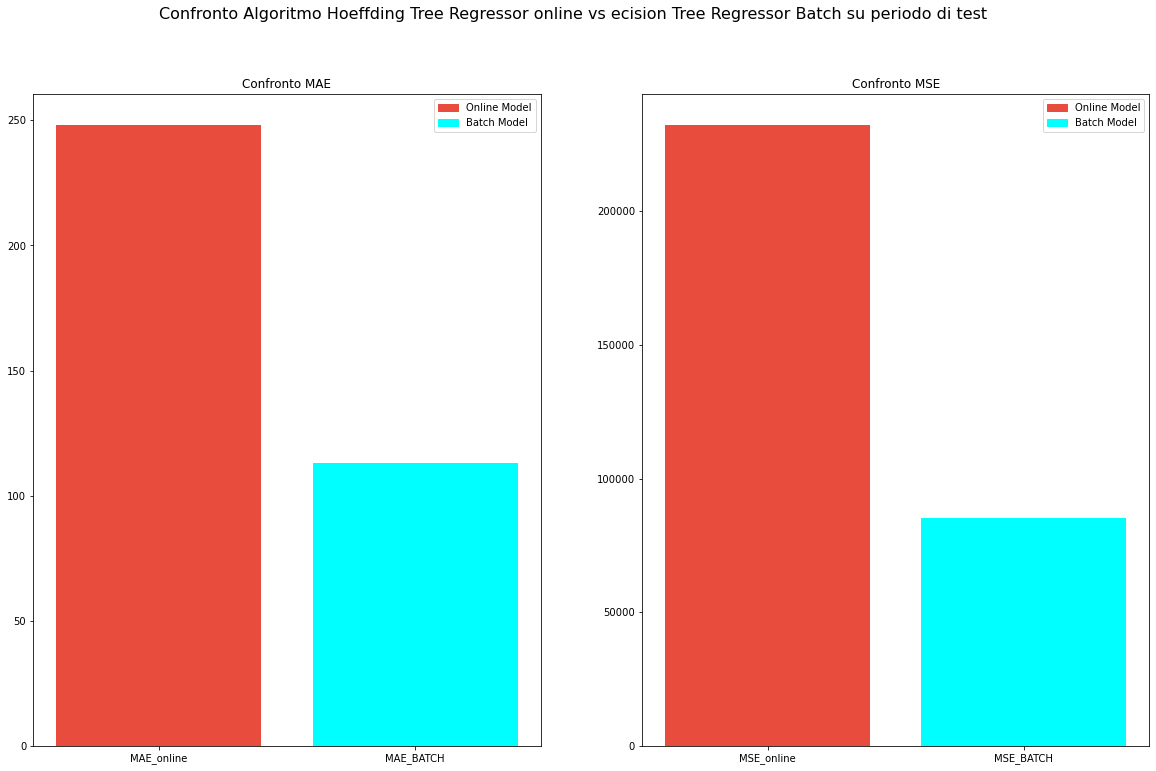

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online vs ecision Tree Regressor Batch su periodo di test',  fontsize=16)

ax1.bar(height=[mean_absolute_error(Y_test_DT, y_preds_dec_tree[-95400::]),mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[mean_squared_error(Y_test_DT, y_preds_dec_tree[-95400::]),mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

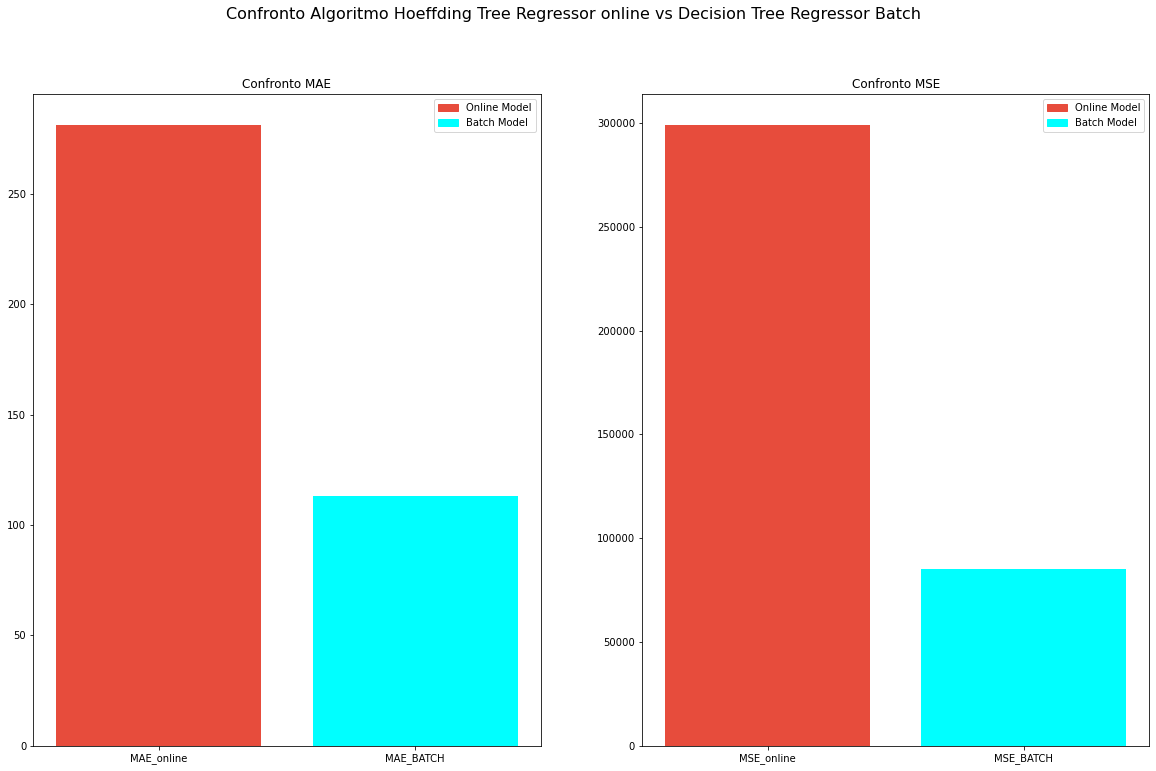

In [89]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('Confronto Algoritmo Hoeffding Tree Regressor online vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[metrics_MAE_dec_tree[-1],mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax2.bar(height=[metrics_MSE_dec_tree[-1],mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

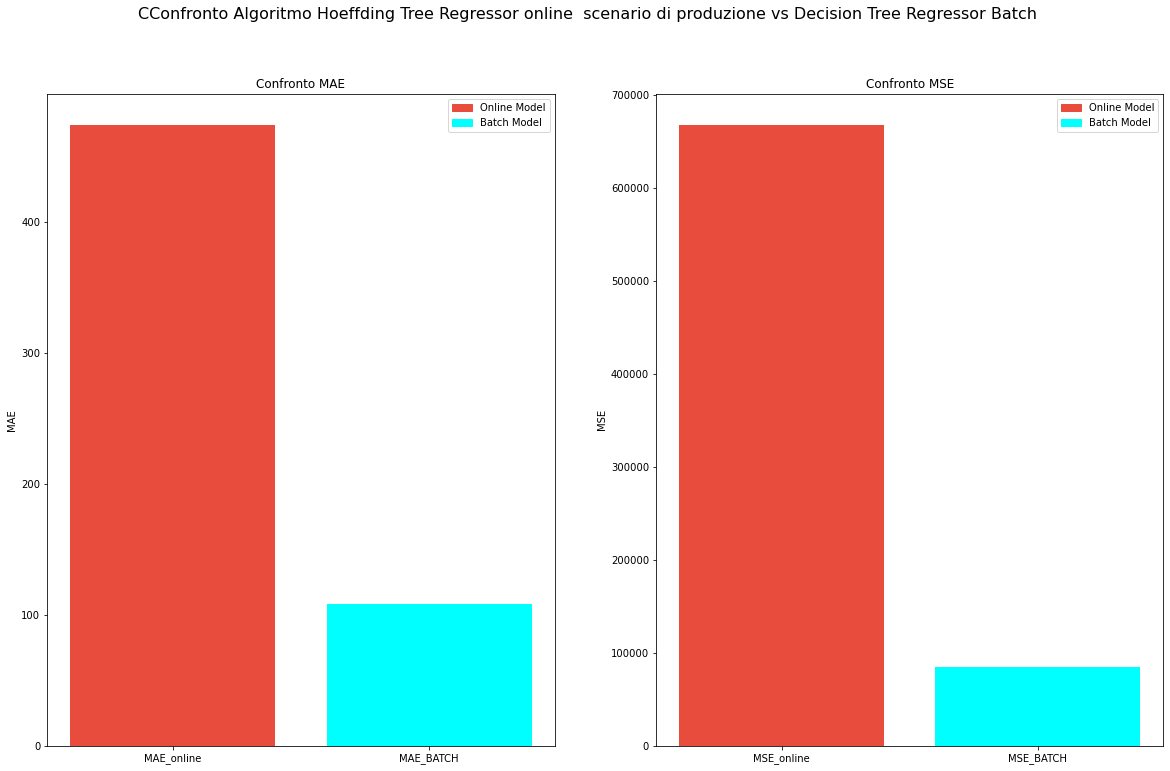

In [90]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 12))

fig.suptitle('CConfronto Algoritmo Hoeffding Tree Regressor online  scenario di produzione vs Decision Tree Regressor Batch',  fontsize=16)

ax1.bar(height=[474.593744,mean_absolute_error(Y_test_DT, regr_mlp.predict(X_test_DT))], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax1.set_title('Confronto MAE')
ax1.set_ylabel('MAE')
ax2.bar(height=[668359.0157,mean_squared_error(Y_test_DT, regr_mlp.predict(X_test_DT))], x=['MSE_online','MSE_BATCH'], color=['#e74c3c', 'cyan'])
ax2.set_title('Confronto MSE')
ax2.set_ylabel('MSE')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax2.legend(handles=[red_patch, cyan_patch])

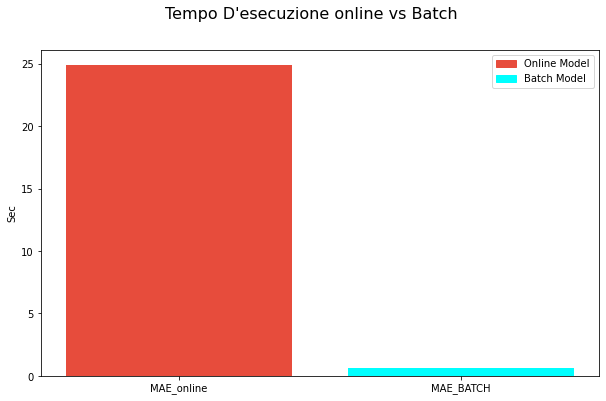

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(height=[24.87821,0.6102404594], x=['MAE_online','MAE_BATCH'], color=['#e74c3c', 'cyan'])
ax.set_ylabel('Sec')

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax.legend(handles=[red_patch, cyan_patch])

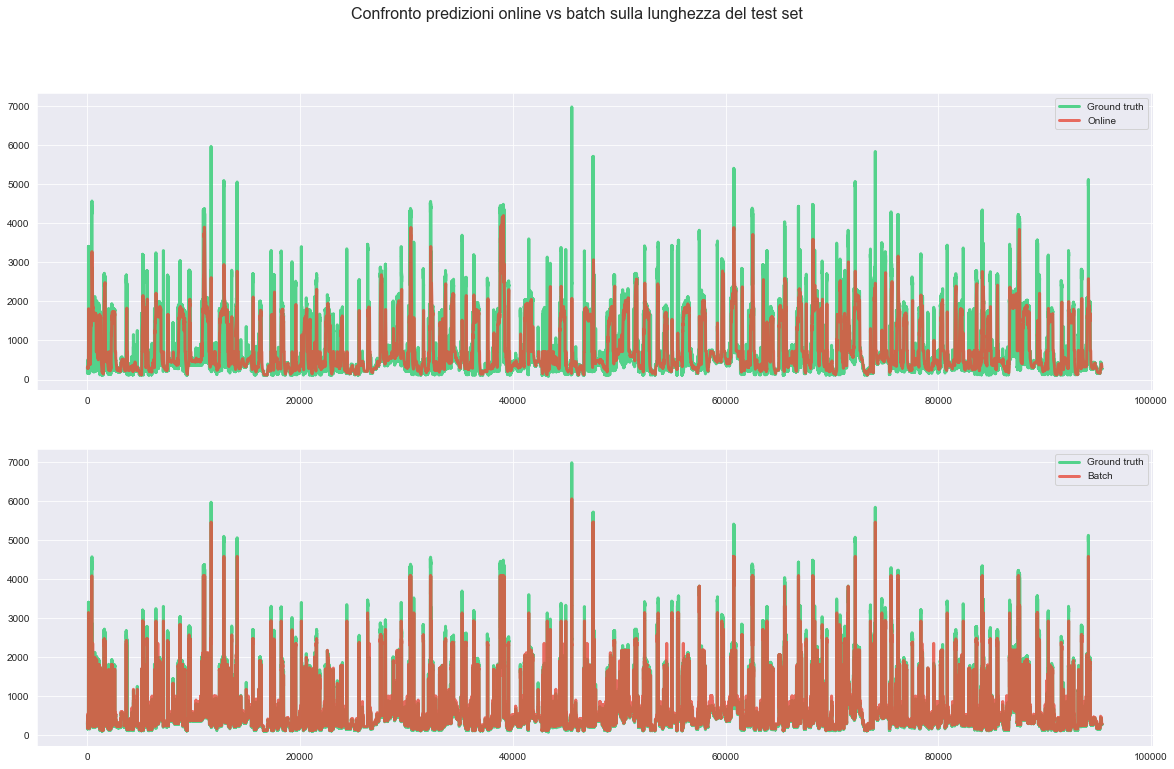

In [20]:
# Plot the results
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax1.plot(y_preds_dec_tree[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='Online')
ax2.plot(result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='Batch')
ax1.legend()
ax2.legend()

## Confronto Totale

Text(0.5, 1.0, 'Confronto MSE')

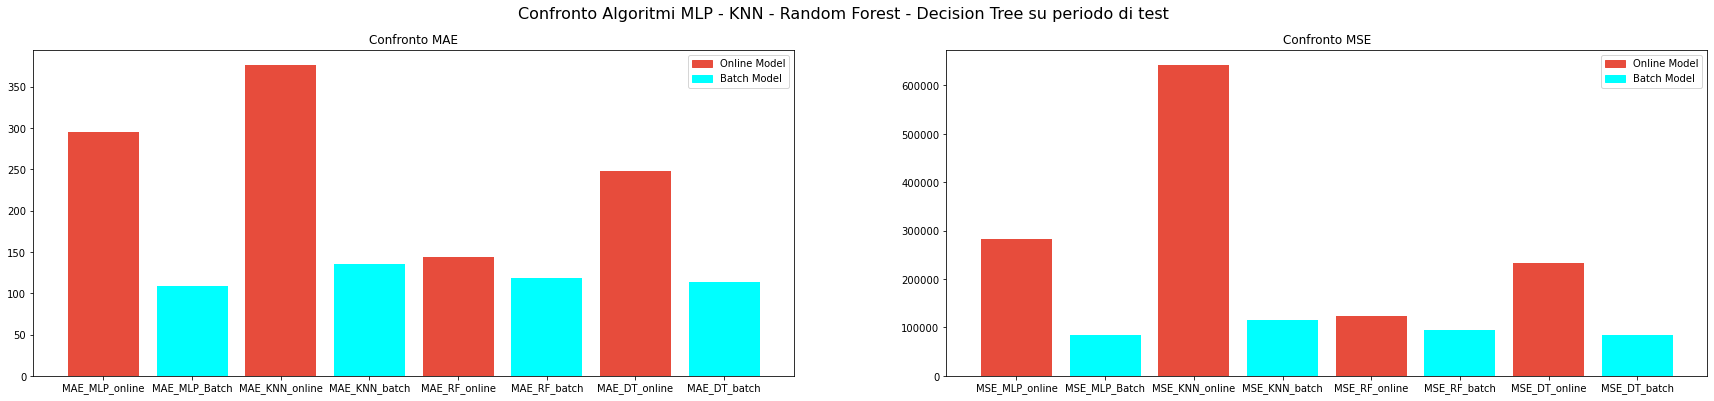

In [93]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree su periodo di test',  fontsize=16)

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')


ax1.bar(height=[
       mean_absolute_error(Y_test_mlp, y_preds_ml_online[-95400::]),mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       mean_absolute_error(Y_test_knm, y_preds_knnreg[-95400::]), mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-95400::]),mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       mean_absolute_error(Y_test_DT, y_preds_dec_tree[-95400::]), mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'])
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       mean_squared_error(Y_test_mlp, y_preds_ml_online[-95400::]),mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       mean_squared_error(Y_test_knm, y_preds_knnreg[-95400::]), mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       mean_squared_error(Y_test_RF, y_preds_ranFor_on[-95400::]),mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       mean_squared_error(Y_test_DT, y_preds_dec_tree[-95400::]), mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')

Text(0.5, 1.0, 'Confronto MSE')

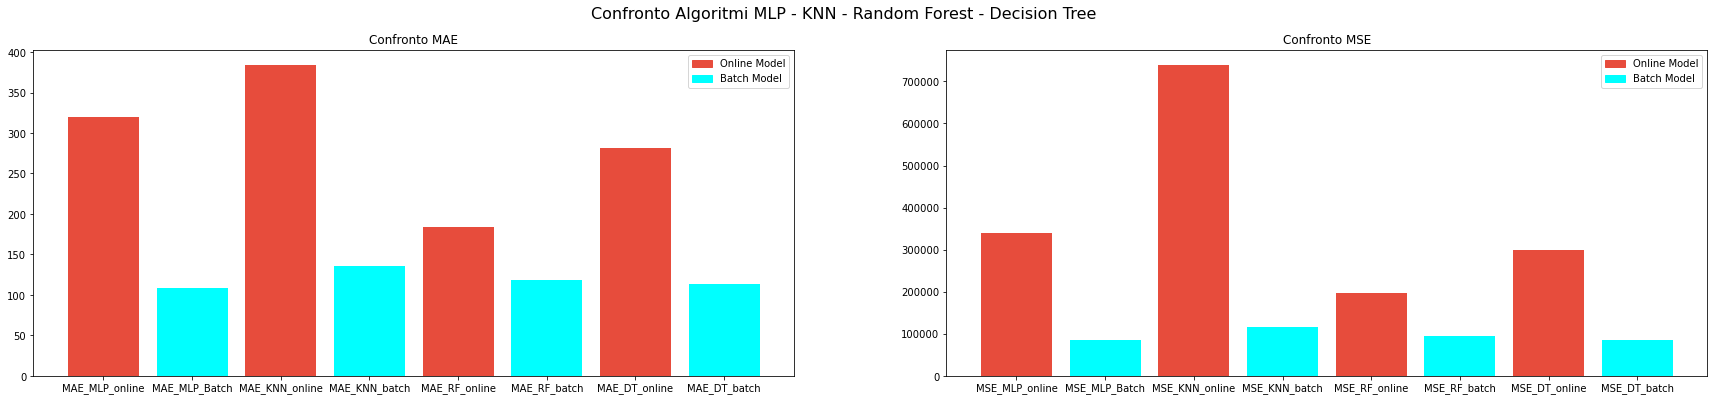

In [94]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree',  fontsize=16)

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')


ax1.bar(height=[
       metrics_MAE_ml_online[-1],mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MAE_knnreg[-1], mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MAE_ranFor_on[-1],mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MAE_dec_tree[-1], mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'])
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       metrics_MSE_ml_online[-1],mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       metrics_MSE_knnreg[-1], mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       metrics_MSE_ranFor_on[-1],mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       metrics_MSE_dec_tree[-1], mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')

Text(0.5, 1.0, 'Confronto MSE')

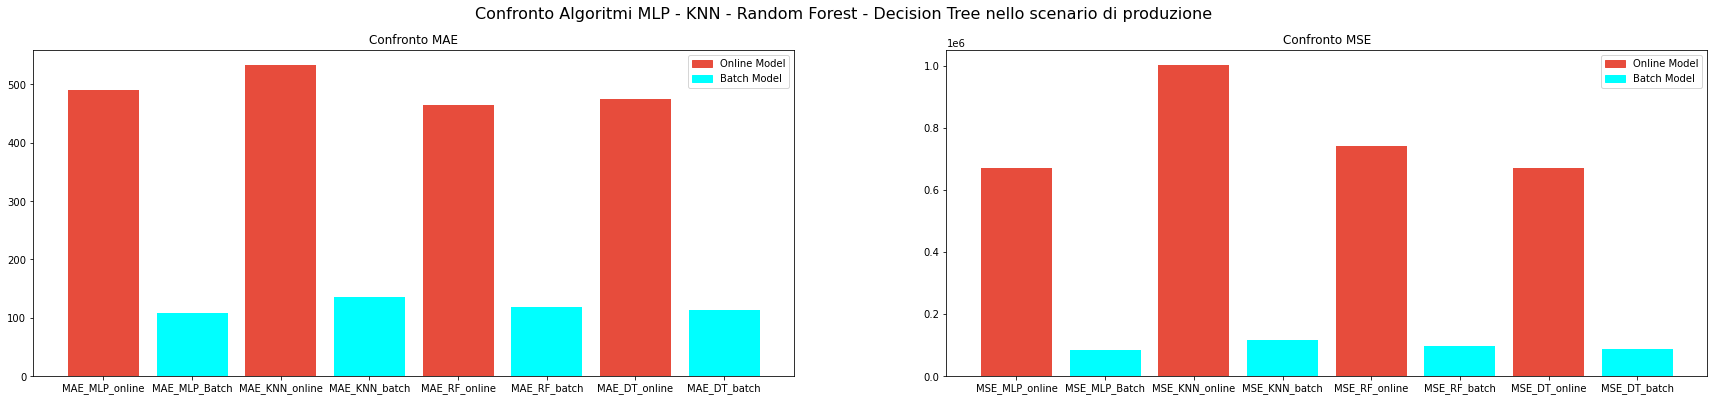

In [95]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30, 6))

fig.suptitle('Confronto Algoritmi MLP - KNN - Random Forest - Decision Tree nello scenario di produzione',  fontsize=16)

ax1.bar(height=[
       491.2728,mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       532.925391, mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
       465.407756,mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       474.593744, mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MAE_MLP_online','MAE_MLP_Batch','MAE_KNN_online','MAE_KNN_batch','MAE_RF_online','MAE_RF_batch','MAE_DT_online','MAE_DT_batch'],
        color=['#e74c3c', 'cyan'],
       )
red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')
ax1.legend(handles=[red_patch, cyan_patch])
ax1.set_title('Confronto MAE')
ax2.bar(height=[
       671038.020,mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
       1000965.580079, mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
       741782.97224,mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
       668359.015795, mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))
                ],
       x=['MSE_MLP_online','MSE_MLP_Batch','MSE_KNN_online','MSE_KNN_batch','MSE_RF_online','MSE_RF_batch','MSE_DT_online','MSE_DT_batch'],
       color=['#e74c3c', 'cyan'])
ax2.legend(handles=[red_patch, cyan_patch])
ax2.set_title('Confronto MSE')




Text(0, 0.5, 'Sec')

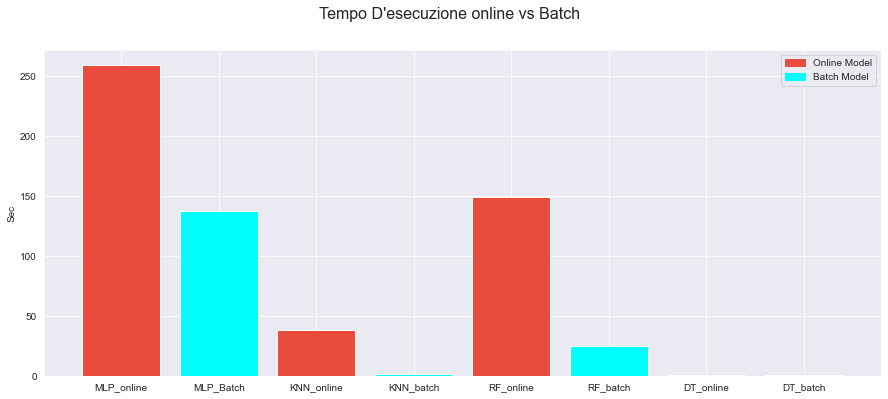

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

red_patch = mpatches.Patch(color='#e74c3c', label='Online Model')
cyan_patch= mpatches.Patch(color='cyan', label='Batch Model')

fig.suptitle('Tempo D\'esecuzione online vs Batch',  fontsize=16)

ax.bar(
       height=[258.914200,137.245078, 37.8227, 1.2499628067, 149.1518952, 24.89266157, 0.9775073528289795, 0.61024059],
       x=['MLP_online','MLP_Batch','KNN_online','KNN_batch','RF_online','RF_batch','DT_online','DT_batch'],
       color=['#e74c3c', 'cyan']
)
ax.legend(handles=[red_patch, cyan_patch])
ax.set_ylabel('Sec')

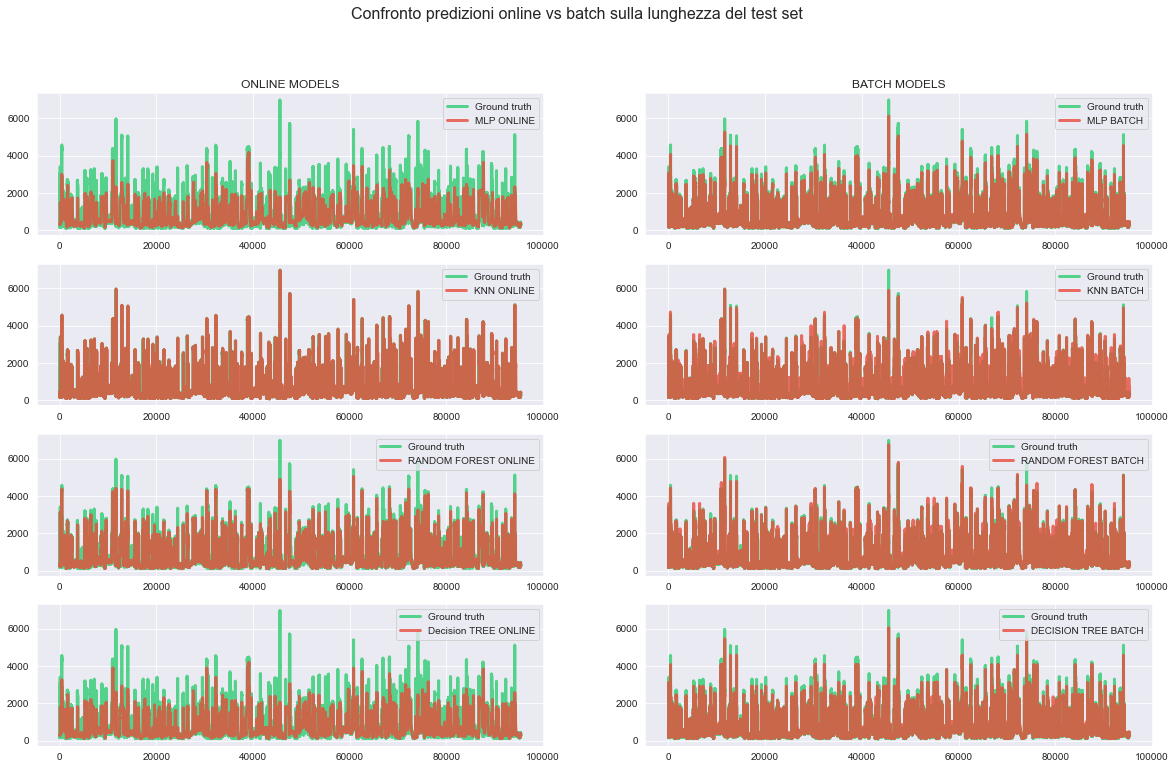

In [21]:
# Plot the results
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(20, 12))
fig.suptitle('Confronto predizioni online vs batch sulla lunghezza del test set',  fontsize=16)
ax.grid(alpha=0.75)
ax1.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax2.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax3.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax4.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax5.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax6.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax7.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax8.plot(Y_test_DT, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')

ax1.plot(y_preds_ml_online[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='MLP ONLINE')

ax2.plot(result_mlpBatch, lw=3, color='#e74c3c', alpha=0.8, label='MLP BATCH')

ax3.plot(y_preds_knnreg[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='KNN ONLINE')

ax4.plot(result_knnreg, lw=3, color='#e74c3c', alpha=0.8, label='KNN BATCH')

ax5.plot(y_preds_ranFor_on[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST ONLINE')

ax6.plot(result_random_forest, lw=3, color='#e74c3c', alpha=0.8, label='RANDOM FOREST BATCH')

ax7.plot(y_preds_dec_tree[-95400::], lw=3, color='#e74c3c', alpha=0.8, label='Decision TREE ONLINE')

ax8.plot(result_dec_tree, lw=3, color='#e74c3c', alpha=0.8, label='DECISION TREE BATCH')


ax1.set_title('ONLINE MODELS')
ax2.set_title('BATCH MODELS')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

## Confronto Batch vs Online - plottare i risultati totali

In [22]:
dati_mae_su_periodo_di_test = {'MAE': [
    mean_absolute_error(Y_test_mlp, y_preds_ml_online[-95400::]),
    mean_absolute_error(Y_test_knm, y_preds_knnreg[-95400::]),
    mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-95400::]),
    mean_absolute_error(Y_test_DT, y_preds_dec_tree[-95400::]),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_su_periodo_di_test = {'MSE': [
    mean_squared_error(Y_test_mlp, y_preds_ml_online[-95400::]),
    mean_squared_error(Y_test_knm, y_preds_knnreg[-95400::]),
    mean_squared_error(Y_test_RF, y_preds_ranFor_on[-95400::]),
    mean_squared_error(Y_test_DT, y_preds_dec_tree[-95400::]),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [23]:
dati_mae_su_periodo_di_test = pd.DataFrame(dati_mae_su_periodo_di_test)
dati_mse_su_periodo_di_test = pd.DataFrame(dati_mse_su_periodo_di_test)

In [53]:
dati_mae_su_periodo_di_test.to_csv('Risultati_Completi/PowerConsuption/dati_mae_su_periodo_di_test')
dati_mse_su_periodo_di_test.to_csv('Risultati_Completi/PowerConsuption/dati_mse_su_periodo_di_test')

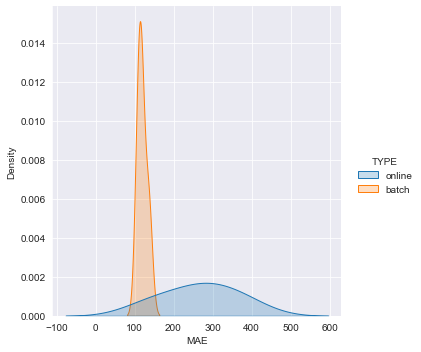

In [27]:
sns.displot(dati_mae_su_periodo_di_test, x='MAE', hue='TYPE',kind="kde", fill=True)

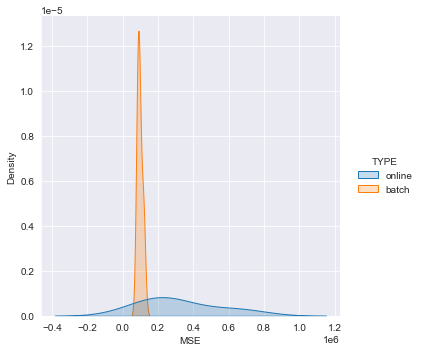

In [28]:
sns.displot(dati_mse_su_periodo_di_test, x='MSE', hue='TYPE',kind="kde", fill=True)

In [29]:
dati_mae = {'MAE': [
    metrics_MAE_ml_online[-1],
    metrics_MAE_knnreg[-1],
    metrics_MAE_ranFor_on[-1],
    metrics_MAE_dec_tree[-1],
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse = {'MSE': [
    metrics_MSE_ml_online[-1],
    metrics_MSE_knnreg[-1],
    metrics_MSE_ranFor_on[-1],
    metrics_MSE_dec_tree[-1],
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [30]:
dati_mae = pd.DataFrame(dati_mae)
dati_mse = pd.DataFrame(dati_mse)

In [52]:
dati_mae.to_csv('Risultati_Completi/PowerConsuption/dati_mae')
dati_mse.to_csv('Risultati_Completi/PowerConsuption/dati_mse')

<AxesSubplot:xlabel='MAE', ylabel='TYPE'>

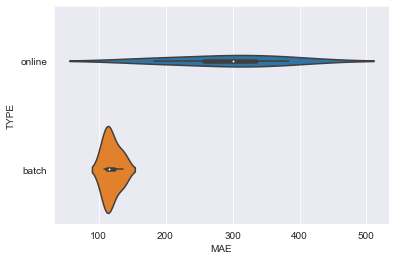

In [31]:
sns.violinplot(x="MAE", y="TYPE", data=dati_mae)

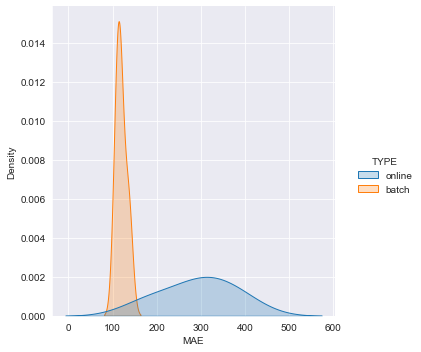

In [32]:
sns.displot(dati_mae, x='MAE', hue='TYPE',kind="kde", fill=True)

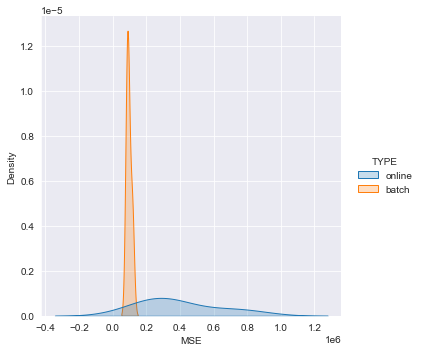

In [33]:
sns.displot(dati_mse, x='MSE', hue='TYPE',kind="kde", fill=True)

In [34]:
dati_mae_production = {'MAE': [
    491.2728,
    532.925391,
    465.407756,
    474.593744,
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_production = {'MSE': [
     671038.020,
    1000965.580079,
    741782.97224,
    668359.015795,
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [35]:
dati_mae_production = pd.DataFrame(dati_mae_production)
dati_mse_production = pd.DataFrame(dati_mse_production)

In [51]:
dati_mae_production.to_csv('Risultati_Completi/PowerConsuption/dati_mae_production')
dati_mse_production.to_csv('Risultati_Completi/PowerConsuption/dati_mse_production')

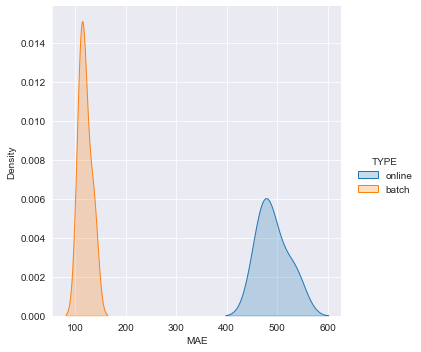

In [36]:
sns.displot(dati_mae_production, x='MAE', hue='TYPE',kind="kde", fill=True)

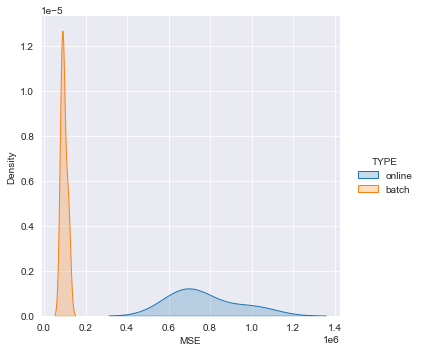

In [37]:
sns.displot(dati_mse_production, x='MSE', hue='TYPE',kind="kde", fill=True)

In [39]:
dati_mae_total = {'MAE': [
    491.2728,
    532.925391,
    465.407756,
    474.593744,
    metrics_MAE_ml_online[-1],
    metrics_MAE_knnreg[-1],
    metrics_MAE_ranFor_on[-1],
    metrics_MAE_dec_tree[-1],
    mean_absolute_error(Y_test_mlp, y_preds_ml_online[-95400::]),
    mean_absolute_error(Y_test_knm, y_preds_knnreg[-95400::]),
    mean_absolute_error(Y_test_RF, y_preds_ranFor_on[-95400::]),
    mean_absolute_error(Y_test_DT, y_preds_dec_tree[-95400::]),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_absolute_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_absolute_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_absolute_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_absolute_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
         'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

dati_mse_total = {'MSE': [
     671038.020,
    1000965.580079,
    741782.97224,
    668359.015795,
    metrics_MSE_ml_online[-1],
    metrics_MSE_knnreg[-1],
    metrics_MSE_ranFor_on[-1],
    metrics_MSE_dec_tree[-1],
    mean_squared_error(Y_test_mlp, y_preds_ml_online[-95400::]),
    mean_squared_error(Y_test_knm, y_preds_knnreg[-95400::]),
    mean_squared_error(Y_test_RF, y_preds_ranFor_on[-95400::]),
    mean_squared_error(Y_test_DT, y_preds_dec_tree[-95400::]),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT)),
    mean_squared_error(Y_test_mlp, regr_mlp.predict(X_test_mlp)),
    mean_squared_error(Y_test_knm, neigh.predict(X_test_knm)),
    mean_squared_error(Y_test_RF, regr_random_forest.predict(X_test_RF)),
    mean_squared_error(Y_test_DT, regressor_dec_tree.predict(X_test_DT))],

    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
        'online',
         'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch',
        'batch'
        ]}

In [40]:
dati_mae_total = pd.DataFrame(dati_mae_total)
dati_mse_total = pd.DataFrame(dati_mse_total)

In [50]:
dati_mae_total.to_csv('Risultati_Completi/PowerConsuption/dati_mae_total')
dati_mse_total.to_csv('Risultati_Completi/PowerConsuption/dati_mse_total')

<AxesSubplot:xlabel='MAE', ylabel='TYPE'>

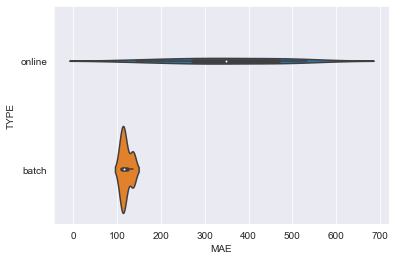

In [41]:
sns.violinplot(x="MAE", y="TYPE", data=dati_mae_total)

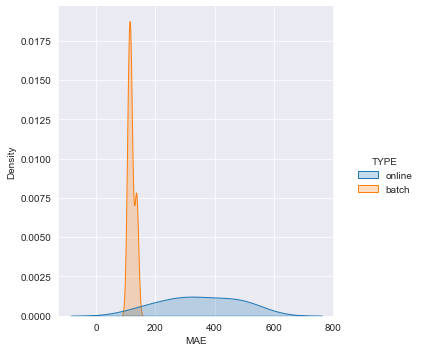

In [42]:
sns.displot(dati_mae_total, x='MAE', hue='TYPE',kind="kde", fill=True)

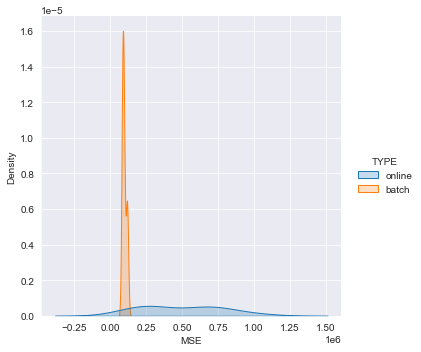

In [43]:
sns.displot(dati_mse_total, x='MSE', hue='TYPE',kind="kde", fill=True)

In [46]:

tempi_execution = {'SEC_of_execution': [
    258.914200,
    37.8227,
    149.1518952,
    24.8782136,
    137.245078,
    1.2499628067,
    0.9775073528289795,
    0.61024059],
    'TYPE': [
        'online',
        'online',
        'online',
        'online',
        'batch',
        'batch',
        'batch',
        'batch'
        ],
    'NUM OF SAMPLE': [
        318000,
        318000,
        318000,
        318000,
        318000,
        318000,
        318000,
        318000
    ]
}

In [47]:
tempi_execution = pd.DataFrame(tempi_execution)

In [49]:
tempi_execution.to_csv('Risultati_Completi/PowerConsuption/tempi_execution')

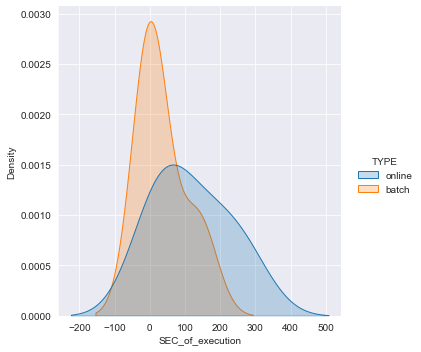

In [48]:
sns.displot(tempi_execution, x='SEC_of_execution', hue='TYPE',kind="kde", fill=True)